# Final Project: Prediksi Pembatalan Reservasi Hotel

**By Hudzaifah Rizqi Kamil**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Package

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder                                    # Label Encoding
from sklearn.model_selection import train_test_split                              # Split Dataset: Train-Test
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif # VIF Score untuk periksa multikolinearitas antar fitur
from statsmodels.tools.tools import add_constant
from imblearn.over_sampling import SMOTE                                          # Oversampling untuk Handling Imbalanced Data
from sklearn.preprocessing import StandardScaler                                  # Stansarisasi

from sklearn.linear_model import LogisticRegression                               # Logistic Regression
from sklearn.tree import DecisionTreeClassifier                                   # Decision Tree
from sklearn.ensemble import RandomForestClassifier                               # Random Forest
from sklearn.svm import SVC                                                       # Support Vector Machine
from sklearn.neural_network import MLPClassifier                                  # Neural Network (MLP)
from xgboost import XGBClassifier                                                 # XGBoost
from lightgbm import LGBMClassifier                                               # LightBGM

from sklearn.model_selection import GridSearchCV                                  # Hyperparameter Tuning + Cross Validation
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay               # Evaluasi Model
from sklearn.inspection import permutation_importance                             # Feature Importance for non-Linear SVM
from sklearn.metrics import RocCurveDisplay

## Load Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Dibimbing DS Bootcamp/Final Project/hotel_booking.csv')
df.head()

hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  customer_type  \
0                        0                     0       2  ...      Transient   
1                        0                     0       2  ...      Transient   
2                        0                     1       1  ...      Transient   
3                        0                     1       1  ...      Transient   
4                        0                     2       2  ...      Transient   

    adr required_car_parking_spaces total_of_special_requests  \
0   0.0                           0                         0   
1   0.0                           0                         0   
2  75.0                           0                         0   
3  75.0                           0                         0   
4  98.0                           0                         1   

  reservation_status reservation_status_date            name  \
0          Check-Out              2015-07-01   Ernest Barnes   
1          Check-Out              2015-07-01    Andrea Baker   
2          Check-Out              2015-07-02  Rebecca Parker   
3          Check-Out              2015-07-02    Laura Murray   
4          Check-Out              2015-07-03     Linda Hines   

                         email  phone-number       credit_card  
0  Ernest.Barnes31@outlook.com  669-792-1661  ************4322  
1       Andrea_Baker94@aol.com  858-637-6955  ************9157  
2   Rebecca_Parker@comcast.net  652-885-2745  ************3734  
3            Laura_M@gmail.com  364-656-8427  ************5677  
4           LHines@verizon.com  713-226-5883  ************5498  

[5 rows x 36 columns]

## Dataset Understanding

**Sumber Dataset:** https://www.kaggle.com/datasets/mojtaba142/hotel-booking

**Tentang Dataset:**

Dataset ini berisi 119390 observasi untuk Hotel Kota dan Hotel Resor. Setiap observasi mewakili pemesanan hotel antara tanggal 1 Juli 2015 dan 31 Agustus 2017, termasuk pemesanan yang benar-benar diterima dan pemesanan yang dibatalkan. Dataset ini adalah data hotel yang sebenarnya, semua elemen data yang berkaitan dengan identifikasi hotel atau pelanggan telah dihapus. Empat Kolom, 'nama', 'email', 'nomor telepon' dan 'kartu kredit' telah dibuat dan ditambahkan secara artifisial ke dalam dataset. Data ini aslinya berasal dari artikel Hotel Booking Demand Datasets, yang ditulis oleh Nuno Antonio, Ana Almeida, dan Luis Nunes untuk Data in Brief, Volume 22, Februari 2019.

---



**Penjelasan Kolom Dataset:**

0.   `hotel`                           : Kumpulan data berisi informasi pemesanan dua hotel. Salah satu hotel adalah hotel resor dan yang lainnya adalah hotel kota.
1.   `is_canceled`                     : Nilai yang menunjukkan apakah pemesanan dibatalkan (1) atau tidak (0).
2.   `lead_time`                       : Jumlah hari yang berlalu antara tanggal pemesanan yang dimasukkan ke PMS dan tanggal kedatangan.
3.   `arrival_date_year`               : Tahun tanggal kedatangan
4.   `arrival_date_month`              : Bulan tanggal kedatangan dengan 12 kategori (Januari hingga Desember)
5.   `arrival_date_week_number`        : Nomor minggu dari tanggal kedatangan (dalam satu tahun hingga 53 minggu)
6.   `arrival_date_day_of_month`       : Tanggal dalam bulan dari tanggal kedatangan (hingga 31 hari)
7.   `stays_in_weekend_nights`         : Jumlah malam akhir pekan (Sabtu atau Minggu) yang ditinggali tamu atau dipesan untuk menginap di hotel
8.   `stays_in_week_nights`            : Jumlah malam dalam seminggu (Senin hingga Jumat) yang ditinggali tamu atau dipesan untuk menginap di hotel BO dan BL/Dihitung dengan menghitung jumlah malam dalam seminggu
9.   `adults`                          : Jumlah orang dewasa
10.  `children`                        : Jumlah anak-anak
11.  `babies`                          : Jumlah bayi
12.  `meal`                            : Paket pemesanan makanan
  - 'Undefined/SC' - tidak ada paket makan;
  - 'BB' - Penginapan dan Sarapan;
  - 'HB' - Half board (sarapan dan satu kali makan lainnya - biasanya makan malam);
  - 'FB' - Full board (sarapan, makan siang dan makan malam);
13.  `country`                         : Negara asal customer. Kategori diwakili dalam format ISO 3155-3:2013
14.  `market_segment`                  : Penunjukan segmen pasar. Dalam kategori, istilah “TA” berarti “Agen Perjalanan” dan “TO” berarti “Operator Tur”
15.  `distribution_channel`            : Saluran distribusi pemesanan. Istilah “TA” berarti “Agen Perjalanan” dan “TO” berarti “Operator Tur”
16.  `is_repeated_guest`               : Nilai yang menunjukkan apakah nama pemesanan berasal dari tamu yang berulang (1) atau tidak (0)
17.  `previous_cancellations`          : Jumlah pemesanan sebelumnya yang dibatalkan oleh pelanggan sebelum pemesanan saat ini
18.  `previous_bookings_not_canceled`  : Jumlah pemesanan sebelumnya yang tidak dibatalkan oleh pelanggan sebelum pemesanan saat ini
19.  `reserved_room_type`              : Kode tipe kamar yang dipesan. Kode ditampilkan sebagai ganti penunjukan untuk alasan anonimitas
20.  `assigned_room_type`              : Kode untuk tipe kamar yang ditetapkan untuk pemesanan. Terkadang tipe kamar yang ditetapkan berbeda dari tipe kamar yang dipesan karena alasan operasional hotel (misalnya pemesanan berlebih) atau atas permintaan pelanggan. Kode disajikan sebagai ganti penunjukan demi alasan anonimitas
21.  `booking_changes`                 : Jumlah perubahan/amendemen yang dibuat pada pemesanan sejak pemesanan dimasukkan pada PMS (Property Management System) hingga saat check-in atau pembatalan
22.  `deposit_type`                    : Indikasi apakah pelanggan telah melakukan deposit untuk menjamin pemesanan. Variabel ini dapat mencakup tiga kategori:
  - 'No Deposit' - tidak ada deposit yang dibuat;
  - 'Non Refund' - deposit dibuat dengan nilai total biaya menginap;
  - 'Refundable' - deposit dibuat dengan nilai di bawah total biaya menginap;
23.  `agent`                           : ID agen perjalanan yang membuat pemesanan
24.  `company`                         : ID perusahaan/entitas yang membuat pemesanan atau yang bertanggung jawab untuk membayar pemesanan. ID disajikan sebagai ganti penunjukan demi alasan anonimitas
25.  `days_in_waiting_list`            : Jumlah hari pemesanan berada dalam daftar tunggu sebelum dikonfirmasi kepada pelanggan
26.  `customer_type`                   : Jenis pemesanan, dengan asumsi salah satu dari empat kategori:
  - 'Contract' - saat pemesanan memiliki jatah atau jenis kontrak lain yang terkait dengannya;
  - 'Group' - saat pemesanan dikaitkan dengan grup;
  - 'Transient' - saat pemesanan bukan bagian dari grup atau kontrak, dan tidak dikaitkan dengan pemesanan sementara lainnya;
  - 'Transient-Party' - saat pemesanan bersifat sementara, tetapi dikaitkan dengan setidaknya pemesanan sementara lainnya;
27.  `adr`                             : Tarif Harian Rata-rata (Dihitung dengan membagi jumlah semua transaksi penginapan dengan jumlah total malam menginap)
28.  `required_car_parking_spaces`     : Jumlah tempat parkir mobil yang dibutuhkan oleh pelanggan
29.  `total_of_special_requests`       : Jumlah permintaan khusus yang dibuat oleh pelanggan (misalnya tempat tidur twin atau lantai tinggi)
30.  `reservation_status`              : Status terakhir reservasi, dengan asumsi salah satu dari tiga kategori:
  - 'Canceled' - pemesanan dibatalkan oleh pelanggan
  - 'Check-Out' - pelanggan telah check-in tetapi sudah meninggalkan hotel
  - 'No-Show' - pelanggan tidak check-in dan tidak memberi tahu hotel tentang alasannya
31.  `reservation_status_date`         : Tanggal saat status terakhir ditetapkan. Variabel ini dapat digunakan bersama dengan ReservationStatus untuk mengetahui kapan pemesanan dibatalkan atau kapan pelanggan check-out dari hotel
32.  `name`                            : Nama customer (tidak asli)
33.  `email`                           : Email customer (tidak asli)
34.  `phone-number`                    : Nomor Telepon customer (tidak asli)
35.  `credit_card`                     : Nomor Kartu Kredit customer (tidak asli)


## Project Objectives (Business Understanding + Goals)

Dalam dataset yang saya gunakan terdapat banyak sekali informasi yang bisa didapatkan dari hasil analisis baik melalui EDA, Feature Engineering maupun pembentukan model machine learning. Namun dalam pengerjaan ini saya ingin berfokus pada sebuah tujuan yakni:

- **Pernyataan Masalah:** Masalah yang ingin diselesaikan terkait dengan Pembatalan reservasi pelanggan hotel. Tujuan utama adalah meminimalkan jumlah pembatalan yang terjadi, sehingga dapat membantu meningkatkan tingkat hunian kamar dan pendapatan hotel.

- **Pihak yang terpengaruh:** Tentu dalam permasalan ini terdapat potensi beberapa pihak yang terpengaruh antara lain
  
  1. Hotel
  - Kerugian Finansial: Kamar yang kosong artinya kehilangan pendapatan potensial.
  - Efisiensi Operasional: Perubahan rencana operasional akibat pembatalan mendadak dapat mengganggu kinerja staf hotel dan meningkatkan biaya.
  - Tingkat Reputasi: Tingkat pembatalan yang tinggi dapat memengeruhi reputasi hotel dan mengurangi kepercayaan calon tamu.
  2. Tamu/Pelanggan
  - Ketidaknyamanan: Jika pembatalan dilakukan oleh pihak hotel (misal overbooking) dapat menyebabkan ketidaknyamanan pada tamu.
  - Kehilangan waktu: Tamu harus mencari alternatif akomodasi lainnya yang mungkin kesulitan dalam proses tersebut.
  3. Platform Reservasi
  - Penurunan pendapatan: Pembatalan dapat mengurangi komisi yang diterima dari transaksi melalui platfrom.
  - Kerusakan reputasi: Jika banyak hotel dalam platfrom memiliki tingkat pembatalan tinggi, maka dapat memengaruhi reputasi platfrom.

- **Skala masalah**
  1. Waktu/Musim: Adanya waktu/musim tertentu yang mungkin mengalami sepi tamu
  2. Lokasi: Terdapat keunggulan tersendiri dari masing-masing lokasi hotel baik dari
    - City Hotel yang terletak di pusat kota, biasanya di kota-kota besar. City hotel sering digunakan oleh para pebisnis dan dikenal sebagai hotel transit. Fasilitas yang ditawarkan biasanya menunjang para pebisnis seperti ruang rapat, meja kerja, dan lainnya atau
    - Resort Hotel yang terletak di kawasan wisata dan rekreasi. Resort hotel difungsikan untuk para wisatawan yang bertujuan berwisata. Resort hotel biasanya berlokasi jauh dari pusat kota dan menawarkan lebih banyak fasilitas untuk tamunya, termasuk pilihan restoran mewah, bar, klub malam dan kasino, layanan spa dan salon lengkap, dan toko ritel eksklusif.
  3. Kebijakan Pembatalan: Kebijakan yang terlalu ketat maupun terlalu fleksibel dapat memengeruhi tingkat pembatalan. Terutama untuk Resort Hotel yang lebih sering dipesan saat liburan daripada City Hotel yang biasanya hanya digunakan untuk transit dan dipesan secara langsung di hari menginap.

- **Mengapa penting untuk diselesaikan?** Dengan menyelesaikan/meminimalkan permasalan ini dapat membantu:
  - Meningkatkan hunian kamar dan tingkat pendapatan,
  - Membantu membentuk perencanaan yang efisien dan menekan biaya operasional,
  - Meningkatkan kepuasan tamu dan mendorong loyalitas,
  - Memperkuat keunggulan posisi kompetitif dengan mengelola insiden pembatalan dengan baik.

- **Tujuan Bisnis:** Membantu mengurangi potensi pembatalan reservasi hotel untuk bulan-bulan selanjutnya. Beberapa matrix evaluasi yang digunakan **(Lebih Prioritas)**:
  1. Accuracy: Mengukur proporsi prediksi yang benar secara keseluruhan. Namun, kurang relevan jika data tidak seimbang (misalnya, jumlah pembatalan jauh lebih sedikit).
  2. **Precision:** Mengukur proporsi prediksi positif (pembatalan) yang benar. Penting jika biaya false positive tinggi (misalnya, menawarkan insentif kepada tamu yang tidak akan membatalkan). Tingkat presisi yang tinggi membantu hotel menargetkan penawaran khusus kepada tamu yang benar-benar berisiko membatalkan, meningkatkan kemungkinan mereka untuk tetap melanjutkan reservasi. Hotel juga bisa mengalokasikan sumber daya layanan pelanggan secara lebih efisien, dengan fokus pada tamu yang paling membutuhkan perhatian.
  3. **Recall:** Mengukur proporsi data positif yang benar-benar diklasifikasikan sebagai positif. Penting jika biaya false negative tinggi (misalnya, tidak mengantisipasi pembatalan dan kehilangan pendapatan). Dengan recall yang tinggi, hotel dapat proaktif dalam mengidentifikasi dan mengatasi masalah yang mungkin menyebabkan tamu membatalkan reservasi, seperti masalah dengan kamar atau layanan. Hotel juga dapat lebih baik dalam mengelola kapasitas kamar, mengurangi risiko overbooking atau underbooking.
  4. F1-Score: Rata-rata harmonik dari precision dan recall. Memberikan keseimbangan antara precision dan recall.

## Data Description

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [ ]:
df.shape

(119390, 36)

Kesimpulan dari dataset:

1. Dataset memiliki 119390 rekam observasi dengan **35 kolom (feature) + 1 kolom (target)**
2. Tipe data yang ada pada dataset: **int64**, **float64** dan **object**

## Data Preprocessing

### Checking Unique Value

In [ ]:
# Memeriksa seluruh unique value pada tiap kolom fitur
for col in df.columns:
    print("{} have {} unique values: {}".format(col, df[col].nunique(), df[col].dtypes))
    if df[col].dtypes == 'int64' or df[col].dtypes == 'float64' or df[col].dtypes == 'object':
        print("{} values: {}".format(col,df[col].unique()))
        print('-' * 100)

hotel have 2 unique values: object
hotel values: ['Resort Hotel' 'City Hotel']
----------------------------------------------------------------------------------------------------
is_canceled have 2 unique values: int64
is_canceled values: [0 1]
----------------------------------------------------------------------------------------------------
lead_time have 479 unique values: int64
lead_time values: [342 737   7  13  14   0   9  85  75  23  35  68  18  37  12  72 127  78
  48  60  77  99 118  95  96  69  45  40  15  36  43  70  16 107  47 113
  90  50  93  76   3   1  10   5  17  51  71  63  62 101   2  81 368 364
 324  79  21 109 102   4  98  92  26  73 115  86  52  29  30  33  32   8
 100  44  80  97  64  39  34  27  82  94 110 111  84  66 104  28 258 112
  65  67  55  88  54 292  83 105 280 394  24 103 366 249  22  91  11 108
 106  31  87  41 304 117  59  53  58 116  42 321  38  56  49 317   6  57
  19  25 315 123  46  89  61 312 299 130  74 298 119  20 286 136 129 124
 327 131 46

Dari hasil pemeriksaan unique value kolom:

1. Terdapat value **'Undefined'** pada fitur `meal`, `market_segment`, `distribution_channel`. Perlu dilakukan analisis lebih lanjut apakah nilai ini akan di handling atau tidak.
2. Untuk kolom `agent` dan `company` memiliki tipe data **'float64'**, lebih mudah jika diubah ke **'int64'**.
3. Fitur yang menunjukkan pada jumlah tamu (adults, children, babies) perlu dilakukan analisis lebih lanjut jika dirasa terdapat data anomali.
4. Fitur yang merujuk pada privasi tamu (`name`, `email`, `phone-number`, dan `credit_card`) lebih baik dihapus saja karena awalnya dibuat dengan dummy dan tidak memengaruhi tujuan analisis.

In [ ]:
df = df.drop(columns=['name','email','phone-number','credit_card']) # menghapus fitur yang mengandung data privasi

### Missing Value

In [ ]:
df.isna().sum()

hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                              16340
company                           112593
days_in_waiting_list                   0
customer_type                          0
adr                                    0
required_car_parking_spaces            0
total_of_special_requests              0
reservation_status                     0
reservation_status_date                0
dtype: int64

Terdapat missing value pada kolom fitur: `children`, `country`, `agent`, dan `company`. Untuk penanganan missing value dilakukan imputasi nilai:
- imputasi nilai nol ke `children`, `agent`, dan `company`
- imputasi 'Undefined' ke missing value di kolom `country`

### Duplicated Data

In [ ]:
df.duplicated().sum()

np.int64(31994)

Data duplikasi diidentifikasi berdasarkan kesamaan seluruh nilai dalam satu observasi. Nama tamu tidak digunakan sebagai kunci utama karena asumsi bahwa satu individu dapat melakukan beberapa pemesanan sekaligus dengan nama yang sama atau terjadi pemesanan di waktu yang sama, namun dengan detail pemesanan yang berbeda ataupun sebaliknya. Maka dari itu:

1. Jumlah penghapusan data duplikat yang sangat banyak akan berakibat memengaruhi nilai statistik dan analisis dalam data.
2. Tidak ada kolom fitur yang dapat dengan pasti dijadikan sebagai nilai unique untuk mengidentifikasi index data. maka **tidak perlu menghapus data duplikat**.

### Numerical Feature Analysis

#### Statistical Descriptive



In [ ]:
df.describe().round(2).T

count     mean     std      min      25%  \
is_canceled                     119390.0     0.37    0.48     0.00     0.00   
lead_time                       119390.0   104.01  106.86     0.00    18.00   
arrival_date_year               119390.0  2016.16    0.71  2015.00  2016.00   
arrival_date_week_number        119390.0    27.17   13.61     1.00    16.00   
arrival_date_day_of_month       119390.0    15.80    8.78     1.00     8.00   
stays_in_weekend_nights         119390.0     0.93    1.00     0.00     0.00   
stays_in_week_nights            119390.0     2.50    1.91     0.00     1.00   
adults                          119390.0     1.86    0.58     0.00     2.00   
children                        119386.0     0.10    0.40     0.00     0.00   
babies                          119390.0     0.01    0.10     0.00     0.00   
is_repeated_guest               119390.0     0.03    0.18     0.00     0.00   
previous_cancellations          119390.0     0.09    0.84     0.00     0.00   
previous_bookings_not_canceled  119390.0     0.14    1.50     0.00     0.00   
booking_changes                 119390.0     0.22    0.65     0.00     0.00   
agent                           103050.0    86.69  110.77     1.00     9.00   
company                           6797.0   189.27  131.66     6.00    62.00   
days_in_waiting_list            119390.0     2.32   17.59     0.00     0.00   
adr                             119390.0   101.83   50.54    -6.38    69.29   
required_car_parking_spaces     119390.0     0.06    0.25     0.00     0.00   
total_of_special_requests       119390.0     0.57    0.79     0.00     0.00   

                                    50%     75%     max  
is_canceled                        0.00     1.0     1.0  
lead_time                         69.00   160.0   737.0  
arrival_date_year               2016.00  2017.0  2017.0  
arrival_date_week_number          28.00    38.0    53.0  
arrival_date_day_of_month         16.00    23.0    31.0  
stays_in_weekend_nights            1.00     2.0    19.0  
stays_in_week_nights               2.00     3.0    50.0  
adults                             2.00     2.0    55.0  
children                           0.00     0.0    10.0  
babies                             0.00     0.0    10.0  
is_repeated_guest                  0.00     0.0     1.0  
previous_cancellations             0.00     0.0    26.0  
previous_bookings_not_canceled     0.00     0.0    72.0  
booking_changes                    0.00     0.0    21.0  
agent                             14.00   229.0   535.0  
company                          179.00   270.0   543.0  
days_in_waiting_list               0.00     0.0   391.0  
adr                               94.58   126.0  5400.0  
required_car_parking_spaces        0.00     0.0     8.0  
total_of_special_requests          0.00     1.0     5.0

Dari hasil statistik deskriptif ditemukan bahwa terdapat nilai negatif pada kolom `adr` (***Averange Daily Rate***). Hal tersebut merupakan anomali yang harus di Drop.

#### Feature Distribution

In [ ]:
nums = df.loc[:, (df.dtypes == 'int64') | (df.dtypes == float)].columns.tolist()

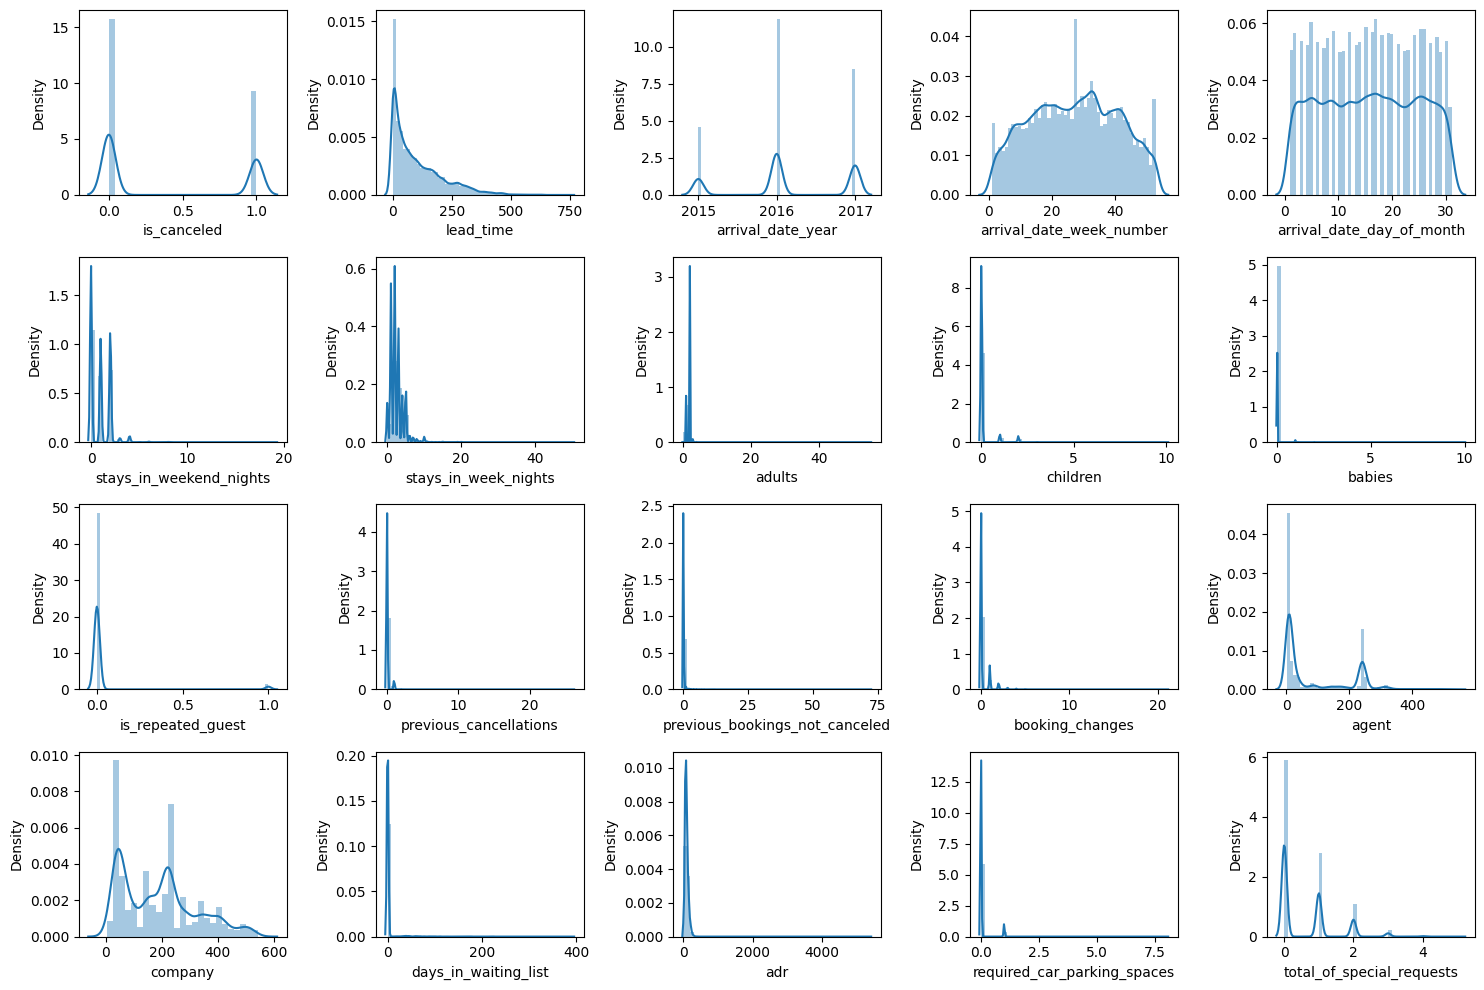

In [ ]:
plt.figure(figsize=(15, 10))
for i in range(0, len(nums)):
    plt.subplot(4, 5, i+1)
    sns.distplot(df[nums[i]])
    plt.tight_layout()

Dari hasil grafik diatas diketahui bahwa mayoritas distribusi fitur numerik cenderung ke *positively skewed*. Sedangkan pada kolom `arrival_date_week_number` dan `arrival_date_day_of_month` memiliki distribusi yang cenderung normal.

#### Checking Outliers

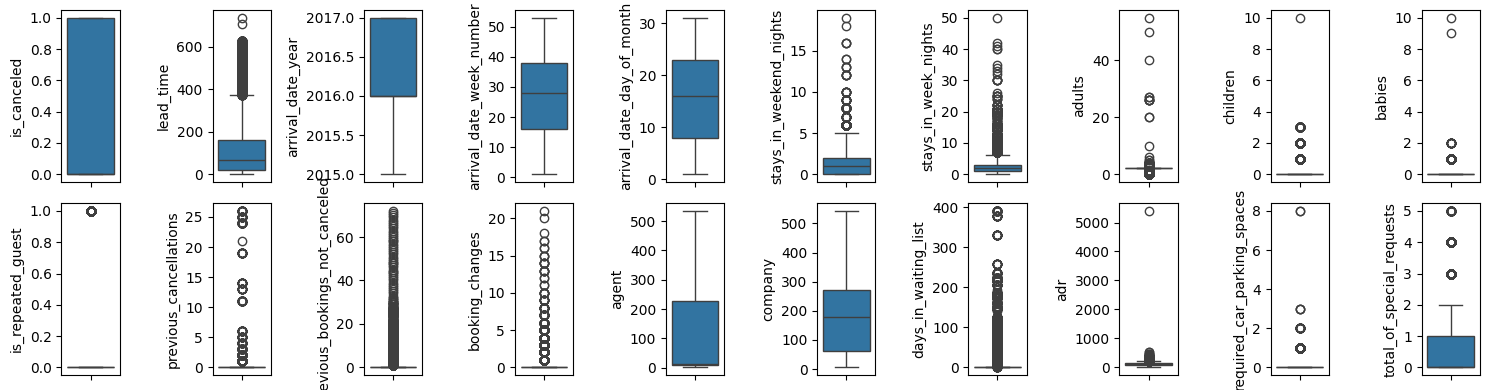

In [ ]:
plt.figure(figsize=(15, 4))
for i in range(0, len(nums)):
    plt.subplot(2, 10, i+1)
    sns.boxplot(y=df[nums[i]], orient='v')
    plt.tight_layout()

Dari hasil Boxplot diatas diketahui:
1. Secara keseluruhan, mayoritas fitur numerik memiliki outliers. Maka, perlu dilakukan analisa kembali apakah nilai tersebut masih termasuk dalam hasil pengumpulan data yang relevan di lapangan (riwayat pemesanan hotel).
2. Terlihat adanya ***Extreme Value*** (nilai yang sangat jauh dari nilai batas boxplot) pada fitur `children`, `babies`, `adr`, dan `required_car_parking_spaces`.

Maka untuk handling outliers akan dilakukan dengan menghilangkan nilai extreme nya saja supaya tidak mengurangi insight yang dihasilkan.

Mencari nilai anomali dari data jumlah tamu dalam tiap rekam jejak dalam riwayat pemesanan hotel. *Pemesanan dibooking, namun tidak ada tamu yang menempati kamar tersebut.

In [ ]:
# Jumlahkan seluruh tamu dalam satu indeks pemesanan
guest_0 = df['adults'] + df['children'] + df['babies']
# Periksa apakah terdapat kamar yang dipesan, namun kosong (tidak ada jumlah tamu yang disertakan dalam pemesanan)
guest_0 = df[guest_0 == 0]
guest_0.shape[0]

180

Dari hasil coding diatas, diketahui terdapat **180 kamar yang ternyata tidak diisi oleh tamu (kosong)**. Meskipun dengan anggapan bahwa pemesanan tetap dilakukan agar bisa digunakan oleh calon tamu sebagai kamar cadangan (misal: rombongan jika dirasa kekurangan kamar dari pemesanan awal), namun hal ini menyebabkan pihak staf hotel tidak bisa bekerja secara efektif karena tidak bisa memperkirakan biaya operasional yang harus dikeluarkan untuk kamar yang kosong tersebut. Untuk handling akan di drop.

### Categorical Feature Analysis

#### Statistical Distribution

In [ ]:
df.describe(exclude=np.number).round(2).T

count unique         top    freq
hotel                    119390      2  City Hotel   79330
arrival_date_month       119390     12      August   13877
meal                     119390      5          BB   92310
country                  118902    177         PRT   48590
market_segment           119390      8   Online TA   56477
distribution_channel     119390      5       TA/TO   97870
reserved_room_type       119390     10           A   85994
assigned_room_type       119390     12           A   74053
deposit_type             119390      3  No Deposit  104641
customer_type            119390      4   Transient   89613
reservation_status       119390      3   Check-Out   75166
reservation_status_date  119390    926  2015-10-21    1461

#### Feature Distribution

In [ ]:
cats = df.loc[:, (df.dtypes == 'object')].columns.tolist()

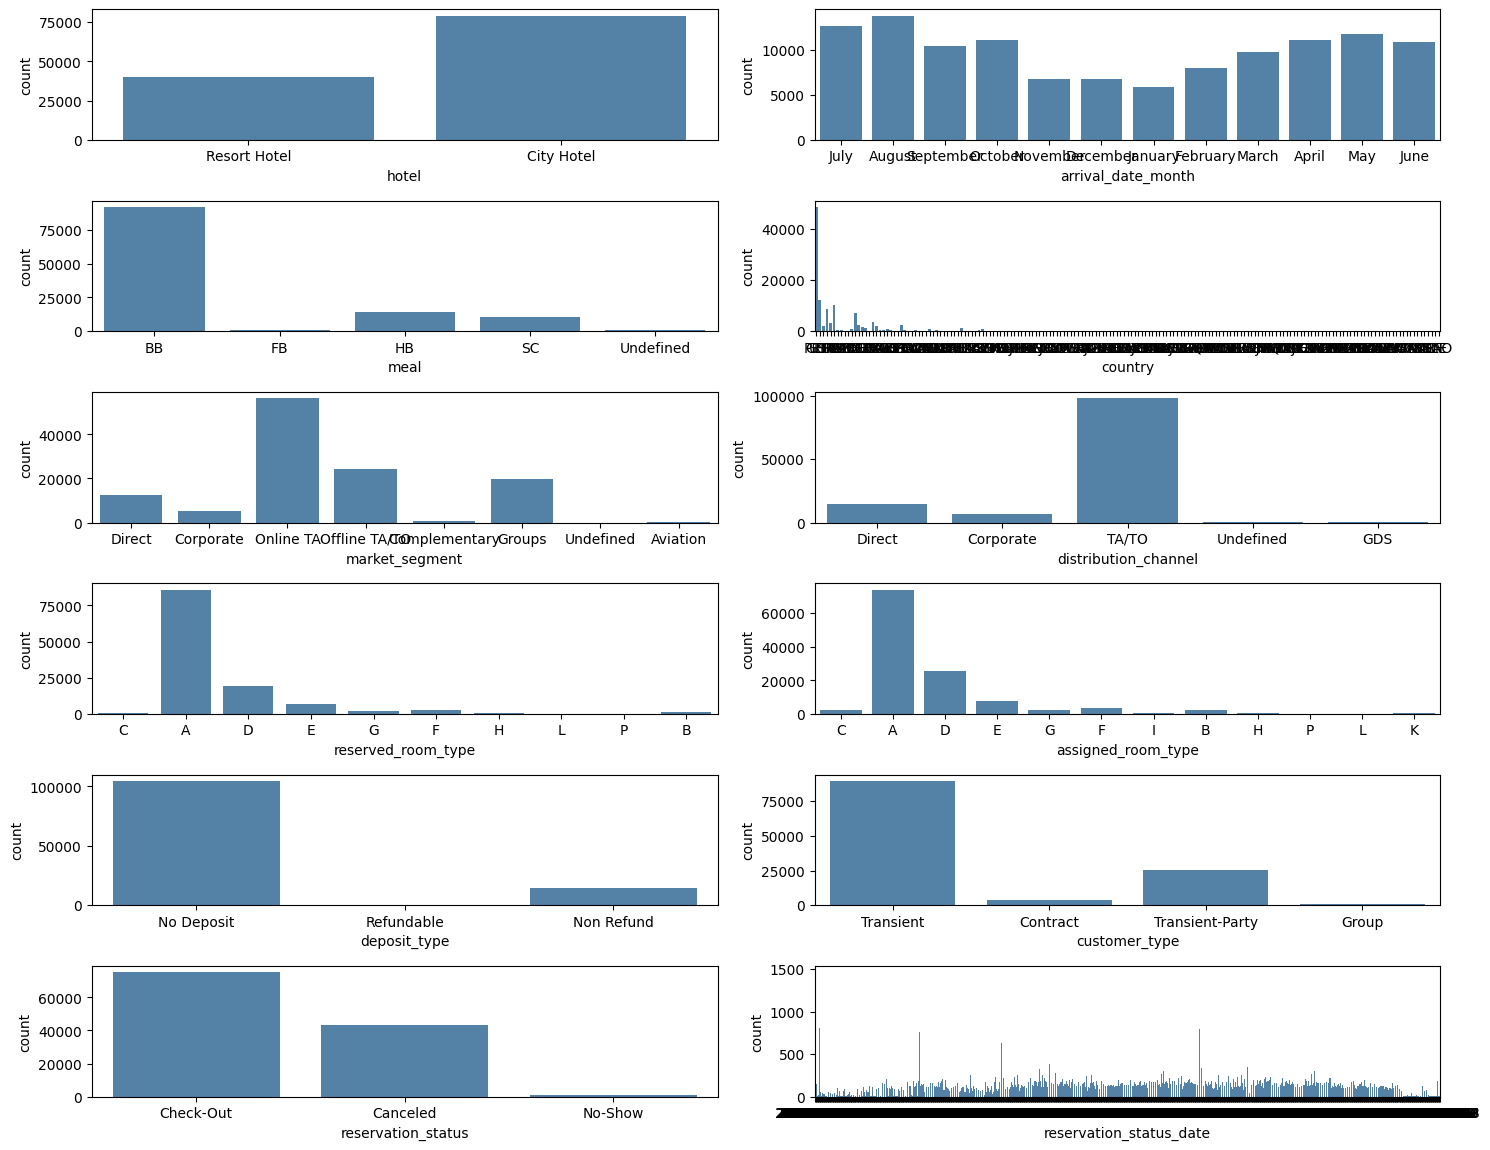

In [ ]:
plt.figure(figsize=(15, 15))

# Adjust the subplot grid to accommodate all categorical features
# The grid should have enough space for all plots
# For 16 plots, you could use a 4x4 grid, 8x2 grid, or another suitable configuration.

# Example using a 4x4 grid:
for i in range(0, len(cats)):
    plt.subplot(8, 2, i+1)
    sns.countplot(x=df[cats[i]], color='steelblue')
    plt.tight_layout()

### Data Cleansing

In [ ]:
df_clean = df.copy()

#### Handling Missing Value

Terdapat empat kolom fitur yang memiliki *missing value* yakni `children`, `country`, `agent`, dan `company` akan dilakukan tindakan sebagai berikut:
1. Missing value pada kolom `children` **diisi dengan 0**, menandakan tamu tidak membawa anak-anak.
2. Missing value pada kolom `agent` **diisi dengan 0**, menandakan bahwa tamu melakukan reservasi secara mandiri atau tidak melalui agen.
3. Missing value pada kolom `company` **diisi dengan 0**, menandakan tamu tidak berasal dari company atau seluruh biaya pemesanan selama di hotel ditanggung secara mandiri.
4. Missing value pada kolom `country` **diisi dengan 'Undefined'**, menandakan asal negara tamu tidak diketahui.

In [ ]:
# Handling Missing Value
# Poin 1, 2, dan 3
ft = ['children', 'agent', 'company']
for col in ft:
    df_clean[col].fillna(0, inplace=True)

# Poin 4
df_clean['country'].fillna('Undefined', inplace=True)

In [ ]:
# Jumlah Missing Value dalam keseluruhan dataset
df_clean.isna().sum().sum()

np.int64(0)

#### Handling Duplicated Data

Berdasarkan analisa sebelumnya, data duplikat tidak akan dihapus dikarenakan:
1. Jumlah data duplikat yang harus dihapus cukup banyak sehingga dikhawatirkan memengaruhi nilai statistik analisis dan kualitas data untuk pembentukan model klasifikasi prediksi machine learning.
2. Tidak ada kolom fitur yang dapat dengan pasti dijadikan sebagai nilai unique untuk mengidentifikasi index data. maka **tidak perlu menghapus data duplikat**

#### Handling Inconsistent and Extreme Values


Pada tahap ini akan di handle data-data yang tidak konsisten (tipe data yang tidak sesuai, dan kategori kelas dalam fitur yang perlu diperjelas) dan nilai ekstrem dalam kolom fitur sebagai berikut:

- Fitur `Meal` dapat dikategorikan menjadi dua kelas, yakni **'With Meal'** dan **'No Meal'** dengan keterangan sebagai berikut:
  1. **With Meal:** BB, HB, dan FB
  2. **No Meal:** SC/Undefined

In [ ]:
df_clean['meal'] = df_clean['meal'].apply(lambda x: 'With Meal' if x in ['BB', 'HB', 'FB'] else 'No Meal')

In [ ]:
df_clean['meal'].unique()

array(['With Meal', 'No Meal'], dtype=object)

In [ ]:
df_clean['meal'].value_counts()

meal
With Meal    107571
No Meal       11819
Name: count, dtype: int64

- Kolom fitur `children` sebaiknya menggunakan tipe data **'int64'**

In [ ]:
df_clean['children'] = df_clean['children'].astype('int64')

- Menghapus nilai ekstrim pada kolom fitur: `children`, `babies`, `adr`, dan `required_car_parking_spaces`.

In [ ]:
# Menghapus nilai ekstrim berdasarkan hasil boxplot pada analisis kolom numerik
# Feature `children`
index_ch = df_clean[(df_clean['children'] == 10)]
df_clean.drop(index = index_ch.index, inplace=True)

# Feature 'babies'
index_bb = df_clean[(df_clean['babies'] > 8)]
df_clean.drop(index = index_bb.index, inplace=True)

# Feature `adr`
index_adr = df_clean[(df_clean['adr'] < 0) | (df_clean['adr'] > 5000)]
df_clean.drop(index = index_adr.index, inplace=True)

# Feature `required_car_parking_spaces`
index_parking = df_clean[(df_clean['required_car_parking_spaces'] == 8)]
df_clean.drop(index = index_parking.index, inplace=True)

- Menghapus nilai anomali pada kamar yang kosong dari booking reservasi (tanpa tamu).

In [ ]:
# Tidak ada tamu
index_guest_0 = df_clean['adults'] + df_clean['children'] + df_clean['babies']
index_guest_0 = df_clean[index_guest_0 == 0]
df_clean.drop(index = index_guest_0.index, inplace=True)

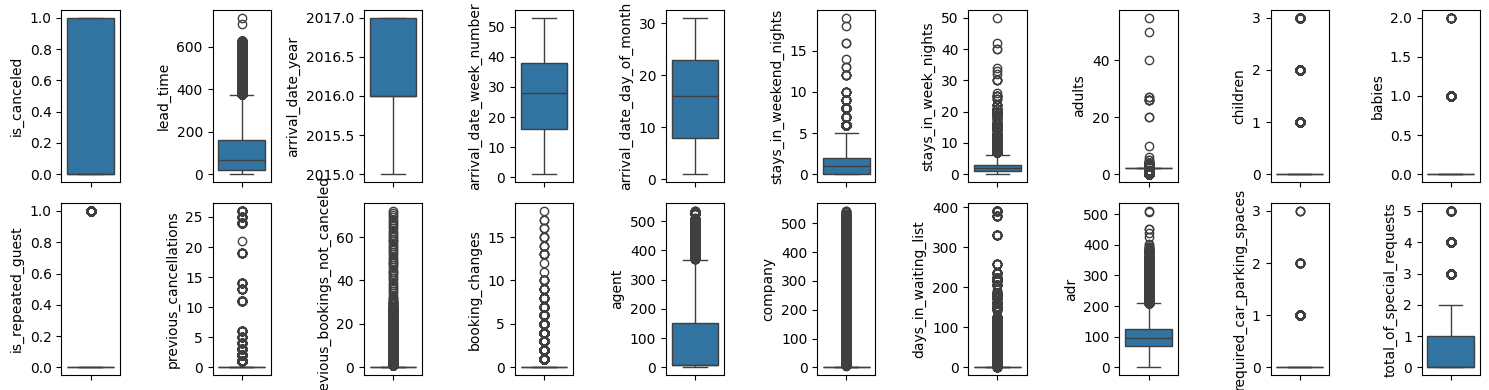

In [ ]:
# Memeriksa kembali outlier pada fitur numerikal
plt.figure(figsize=(15, 4))
for i in range(0, len(nums)):
    plt.subplot(2, 10, i+1)
    sns.boxplot(y=df_clean[nums[i]], orient='v')
    plt.tight_layout()

In [ ]:
df_clean.isna().sum().sum()

np.int64(0)

In [ ]:
df_clean.duplicated().sum()

np.int64(31980)

In [ ]:
print('Total Index sebelum proses Cleaning :', df.shape[0])
print('Total Index setelah proses Cleaning :', df_clean.shape[0])

Total Index sebelum proses Cleaning : 119390
Total Index setelah proses Cleaning : 119203


Setelah melalui proses Cleaning, data telah bersih dari missing value dan mempertahankan nilai duplikat dengan pertimbangan yang telah dianalisis untuk menjaga informasi penting menjadikan ukuran index dataset yang semula 119390 menjadi 119203 atau tingkat kehilangan data sebesar 0.16%.

## Exploratory Data Analysis (EDA)

Sebelum menganalisis objek permasalahan yang ingin diselesaikan ada beberapa hal yang bisa menjadi asumsi dan hypothesis awal terkait faktor penyebab terjadinya pembatalan reservasi hotel:

- **Asumsi:**
  1. Antara tahun 2015 dan 2017, tidak ada kejadian penting atau insiden tak terduga yang berdampak besar pada data yang dipertimbangkan.
  2. Faktor paling signifikan yang memengaruhi perolehan pendapatan adalah terjadinya pembatalan pemesanan.
  3. Pembatalan mengakibatkan kamar tidak terisi selama durasi pemesanan.
  4. Tamu biasanya membuat reservasi hotel di tahun yang sama saat mereka membatalkannya.

- **Hypothesis:**
  1. Pembatalan lebih banyak terjadi saat harga lebih tinggi.
  2. Saat daftar tunggu lebih panjang, pelanggan cenderung lebih sering membatalkan reservasi.
  3. Mayoritas klien datang dari agen perjalanan offline untuk melakukan reservasi.

Fokus utama dengan kolom fitur: Mencari faktor-faktor yang mungkin menyebabkan adanya pembatalan reservasi.
1. Mencari perbandingan jumlah tidak pembatalan dan terjadi pembatalan (`is_canceled`)
2. Tingkat pembatalan berdasarkan jenis hotel (`hotel` + `is_canceled`)
3. Tingkat pembatalan berdasarkan lama delay waktu dari pemesanan hingga kedatangan (`lead_time` + `is_canceled`)
4. Tingkat pembatalan berdasarkan lama waktu tunggu antrian booking (`days_in_waiting_list` + `is_canceled`)
5. Tingkat pembatalan berdasarkan segment pasar (`market_segment` + `is_canceled`)
6. Analisis Jumlah Pembatalan per Bulan (Juli 2015 - Agustus 2017) + ADR (`reservation_status_date_year` + `is_canceled` + `adr`)
7. Analisis Jumlah Pembatalan dari asal negara pelanggan (`country` + `is_canceled`)
8. Analisis Jumlah Pembatalan yang disebabkan akibat perubahan kamar yang di pesan (`reserved_room_type` + `assigned_room_type` + `is_canceled`)
9. Analisis Jumlah Pembatalan berdasarkan riwayat pemesanan sebelumnya (`is_repeated_guest` + `previous_cancellations` + `previous_bookings_not_canceled` + `is_canceled`)
10. Analisis Jumlah Pembatalan melalui pemesanan lewat agen perjalanan yang dilakukan sendiri oleh klien (`agent` + `is_canceled`)
11. Analisis Jumlah Pembatalan melalui pemesanan lewat perusahaan (`company` + `is_canceled`)
12. Analisis Jumlah Pembatalan berdasarkan jaminan/deposit yang telah diberikan klien ke pihak hotel (`deposit_type` + `is_canceled`)
13. Analisis Jumlah Pembatalan berdasarkan fasilitas dari pihak hotel yang telah di pesan oleh tamu (`meal` + `required_car_parking_spaces` + `total_of_special_requests` + `is_canceled`)

- **Manajemen transaksi, administrasi, dan komunikasi hotel** (poin 3, 4, 7, 8, 9, 12)
- **Keterbatasan fasilitas hotel yang di pesan tamu** (poin 5, 8, 13)
- **Cara melakukan pemesanan/reservasi atau melalui perantara pihak ketiga** (poin 10, 11)
- Faktor lainnya (.etc)


In [ ]:
df_eda = df_clean.copy()

- Mencari perbandingan jumlah tidak pembatalan dan terjadi pembatalan

In [ ]:
# Jumlah pembatalan reservasi keseluruhan
cancel_count = df_eda['is_canceled'].value_counts()
cancel_count

is_canceled
0    75006
1    44197
Name: count, dtype: int64

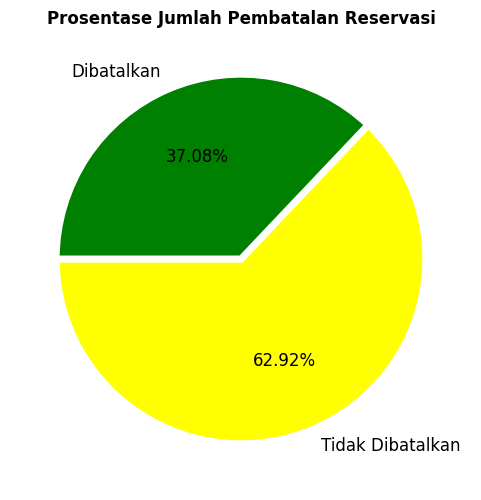

In [ ]:
plt.subplots(figsize=(6, 6))
labels = ['Tidak Dibatalkan', 'Dibatalkan']
colors = ['yellow','green'] # Bisa diisi dengan Hex color codes
plt.pie(cancel_count,
        labels=labels,
        autopct='%.2f%%',
        wedgeprops={'linewidth': 5.0, 'edgecolor': 'white'},
        colors=colors,
        textprops={'size': 'large'},
        startangle=180)

plt.title('Prosentase Jumlah Pembatalan Reservasi', fontsize=12, pad=3, loc='center', fontweight='bold')
plt.show()

Data target lebih di dominasi oleh bagian tidak membatalkan daripada target yang ingin dicari yakni membatalkan (Data imbalanced).

- Tingkat pembatalan berdasarkan jenis hotel

In [ ]:
# Jumlah pembatalan berdasarkan jenis hotel
cancel_hotel = df_eda.groupby('hotel')['is_canceled'].value_counts()
cancel_hotel

hotel         is_canceled
City Hotel    0              46082
              1              33078
Resort Hotel  0              28924
              1              11119
Name: count, dtype: int64

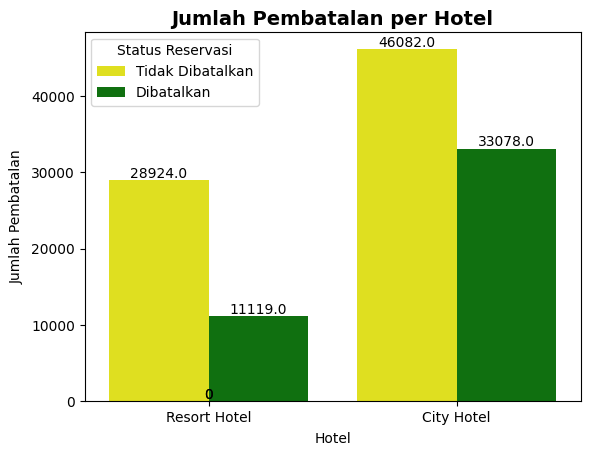

In [ ]:
sns.countplot(x='hotel', hue='is_canceled', data=df_eda, palette=colors)
plt.title('Jumlah Pembatalan per Hotel', fontsize=14, pad=5, loc='center', fontweight='bold')
plt.xlabel('Hotel', labelpad=5)
plt.ylabel('Jumlah Pembatalan', labelpad=5)
plt.legend(title='Status Reservasi', labels=labels, loc='upper left')
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5),
                textcoords='offset points')
plt.show()

Jumlah pembatalan reservasi lebih banyak dilakukan pada `City_Hotel`


- Tingkat pembatalan berdasarkan lama delay waktu dari pemesanan hingga kedatangan

In [ ]:
# Jumlah pembatalan berdasarkan delay waktu pemesanan hingga kedatangan
cancel_lead_time = df_eda.groupby('lead_time')['is_canceled'].value_counts()
cancel_lead_time

lead_time  is_canceled
0          0              5847
           1               417
1          0              3127
           1               318
2          0              1852
                          ... 
622        1                17
626        1                30
629        1                17
709        0                 1
737        0                 1
Name: count, Length: 887, dtype: int64

In [ ]:
# Buat kategori lama waktu jeda antara pemesanan ke hari kedatangan
df_eda['lead_time_category'] = pd.cut(df_eda['lead_time'], bins=[0, 7, 14, 30, 60, float('inf')],
                                  labels=['0-7 hari', '8-14 hari', '15-30 hari', '31-60 hari', '>60 hari'])

# Kelompokkan data dan hitung jumlah pembatalan
cancel_hotel_time = df_eda.groupby(['hotel', 'lead_time_category', 'is_canceled']).size().reset_index(name='count')

# Filter hanya pembatalan (is_canceled=1)
cancel_hotel_time = cancel_hotel_time[cancel_hotel_time['is_canceled'] == 1]

# Urutkan dan ambil 5 teratas
top_10_cancels_lead = cancel_hotel_time.sort_values(by='count', ascending=False).head(10).reset_index(drop='index')

top_10_cancels_lead

hotel lead_time_category  is_canceled  count
0    City Hotel           >60 hari            1  23287
1  Resort Hotel           >60 hari            1   7570
2    City Hotel         31-60 hari            1   4607
3    City Hotel         15-30 hari            1   2747
4  Resort Hotel         31-60 hari            1   1565
5    City Hotel          8-14 hari            1   1133
6    City Hotel           0-7 hari            1   1042
7  Resort Hotel         15-30 hari            1    990
8  Resort Hotel           0-7 hari            1    426
9  Resort Hotel          8-14 hari            1    413

Dari data tersebut diketahui bahwa pembatalan reservasi lebih banyak terjadi ketika telah melewati **lebih dari satu sampai dua bulan rentang antara pemesanan hingga tanggal kedatangan**. Pembatalan reservasi cenderung lebih sering terjadi pada `City_Hotel` sedangkan pada `Resort_Hotel` banyak terjadi pembatalan hingga dua bulan lebih sebelum tanggal kedatangan dan beberapa minggu pertama.

*pd.cut: Membuat kategori lama waktu tunggu berdasarkan rentang yang ditentukan.

- Tingkat pembatalan berdasarkan lama waktu tunggu antrian booking

In [ ]:
# Jumlah pembatalan berdasarkan lama waktu tunggu
cancel_days_in_waiting_list = df_eda.groupby('days_in_waiting_list')['is_canceled'].value_counts()
cancel_days_in_waiting_list

days_in_waiting_list  is_canceled
0                     0              73673
                      1              41838
1                     0                  9
                      1                  3
2                     0                  4
                                     ...  
330                   0                 14
                      1                  1
379                   1                  9
                      0                  6
391                   1                 45
Name: count, Length: 202, dtype: int64

In [ ]:
# Buat kategori lama waktu jeda untuk waiting list
df_eda['waiting_time_category'] = pd.cut(df_eda['days_in_waiting_list'], bins=[0, 7, 14, 30, 60, float('inf')],
                                  labels=['0-7 hari', '8-14 hari', '15-30 hari', '31-60 hari', '>60 hari'])

# Kelompokkan data dan hitung jumlah pembatalan
cancel_hotel_wait = df_eda.groupby(['hotel', 'waiting_time_category', 'is_canceled']).size().reset_index(name='count')

# Filter hanya pembatalan (is_canceled=1)
cancel_hotel_wait = cancel_hotel_wait[cancel_hotel_wait['is_canceled'] == 1]

# Urutkan dan ambil 5 teratas
top_10_cancels_wait = cancel_hotel_wait.sort_values(by='count', ascending=False).head(10).reset_index(drop='index')

top_10_cancels_wait

hotel waiting_time_category  is_canceled  count
0    City Hotel            31-60 hari            1   1058
1    City Hotel              >60 hari            1    842
2    City Hotel            15-30 hari            1    313
3    City Hotel              0-7 hari            1     76
4    City Hotel             8-14 hari            1     53
5  Resort Hotel              >60 hari            1      7
6  Resort Hotel            31-60 hari            1      5
7  Resort Hotel              0-7 hari            1      3
8  Resort Hotel            15-30 hari            1      1
9  Resort Hotel             8-14 hari            1      1

Untuk pembatalan reservasi berdasarkan waiting list dimana pemesanan berada dalam daftar tunggu sebelum dikonfirmasi kepada pelanggan oleh pihak hotel. Dari hasil ini lebih di domnasi oleh city hotel dimana kemungkinan selalu penuh oleh pelanggan lain atau tidak tersedianya kamar sesuai jumlah permintaan sehingga harus menunggu pihak hotel terkait untuk memastikan ketersediaan kamar.

- Tingkat pembatalan berdasarkan segment pasar

In [ ]:
# Jumlah pembatalan berdasarkan channel distribusi
cancel_segment = df_eda.groupby('market_segment')['is_canceled'].value_counts()
cancel_segment

market_segment  is_canceled
Aviation        0                183
                1                 52
Complementary   0                639
                1                 89
Corporate       0               4290
                1                991
Direct          0              10646
                1               1934
Groups          1              12094
                0               7696
Offline TA/TO   0              15880
                1               8300
Online TA       0              35672
                1              20735
Undefined       1                  2
Name: count, dtype: int64

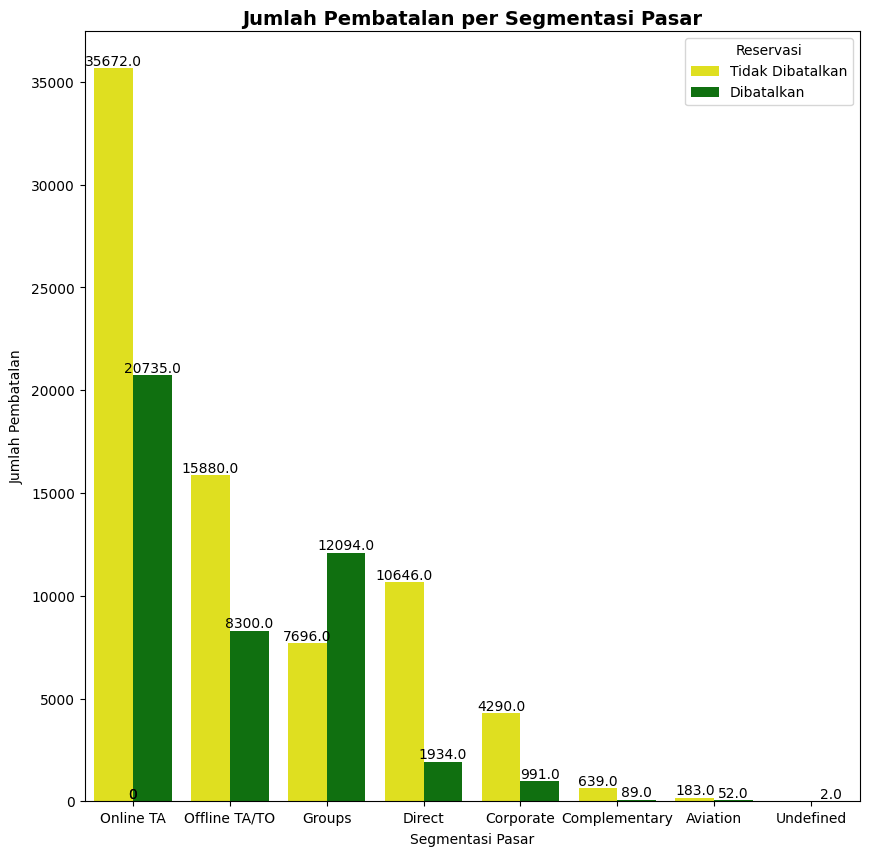

In [ ]:
plt.figure(figsize=(10,10))

sns.countplot(x='market_segment', hue='is_canceled', data=df_eda, palette=colors, order=df_eda['market_segment'].value_counts().index)
plt.title('Jumlah Pembatalan per Segmentasi Pasar', fontsize=14, pad=5, loc='center', fontweight='bold')
plt.xlabel('Segmentasi Pasar', labelpad=5)
plt.ylabel('Jumlah Pembatalan', labelpad=5)
plt.legend(title='Reservasi', labels=labels, loc='upper right')
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5),
                textcoords='offset points')
plt.show()

Berdasarkan segmentasi pasar, lebih banyak terjadi pembatalan reservasi melalui pemesanan Online TA(Agen Perjalanan)/TO(Operator Tur). Ini mengindikasikan bahwa pelanggan lebih mudah melakukan reservasi melalui online, namun juga lebih rentan untuk membatalkan reservasinya. Kemudian untuk reservasi oleh group lebih banyak melakukan pembatalan daripada reservasi yang tidak membatalkan. Ini dapat diasumsikan mungkin adanya ketidaksesuaian fasilitas/pelayanan yang ditawarkan khusus untuk pemesanan group atau mungkin kurangnya Hotel yang menyediakan kriteria yang diinginkan (asumsi terlepas dari adanya kesalahan pemesanan oleh individu).

- Analisis Jumlah Pembatalan per Bulan (Juli 2015 - Agustus 2017) + ADR

In [ ]:
# Mengubah tipe data menjadi datetime
df_eda['reservation_status_date'] = pd.to_datetime(df_eda['reservation_status_date'])

# Memisahkan menjadi kolom baru
df_eda['reservation_status_date_year'] = df_eda['reservation_status_date'].dt.year
df_eda['reservation_status_date_month'] = df_eda['reservation_status_date'].dt.month
df_eda['reservation_status_date_day'] = df_eda['reservation_status_date'].dt.day

In [ ]:
# Menggabungkan kolom month dan year
df_eda['month_year'] = df_eda['reservation_status_date_year'].astype(str) + '-' + df_eda['reservation_status_date_month'].astype(str)

# menghitung jumlah pembatalan per-bulan
Rev_stat_per_month_year=df_eda.groupby('month_year')['is_canceled'].value_counts().reset_index()
Rev_stat_per_month_year

month_year  is_canceled  count
0     2014-10            1    180
1     2014-11            1      1
2      2015-1            1    948
3     2015-10            0   3297
4     2015-10            1   2438
..        ...          ...    ...
56     2017-7            0   3332
57     2017-7            1    702
58     2017-8            0   3097
59     2017-8            1    318
60     2017-9            0    393

[61 rows x 3 columns]

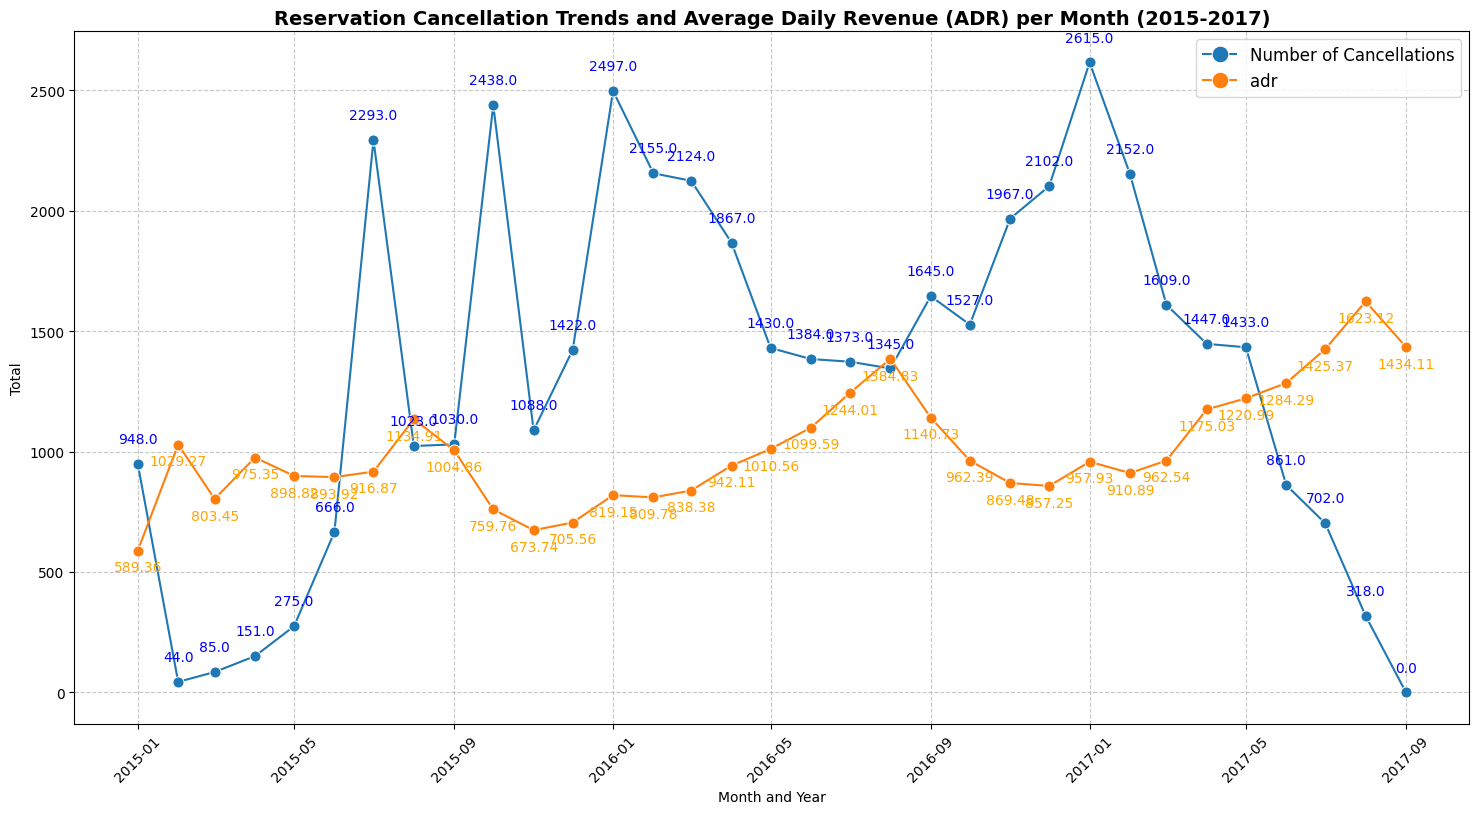

In [ ]:
# Tren pembatalan reservasi hotel July2015 - August2017 + ADR
# Filter data untuk tahun 2015-2017
df_edafilter = df_eda[(df_eda['reservation_status_date_year'] >= 2015) & (df_eda['reservation_status_date_year'] <= 2017)]

# Hitung jumlah pembatalan dan rata-rata pendapatan (ADR) per bulan
df_monthly = df_edafilter.groupby('month_year').agg({'is_canceled': 'sum', 'adr': 'mean'}).reset_index()

# Konversi 'month_year' ke datetime
df_monthly['month_year'] = pd.to_datetime(df_monthly['month_year'], format='%Y-%m')

# Urutkan data berdasarkan 'month_year'
df_monthly = df_monthly.sort_values(by='month_year')

# Set 'month_year' sebagai index
df_monthly.set_index('month_year', inplace=True)

# Perbesar nilai ADR untuk memudahkan analisa
df_monthly['adr'] = df_monthly['adr'] * 10

# Buat line chart
plt.figure(figsize=(18,9))
sns.lineplot(x='month_year', y='is_canceled', data=df_monthly, label='Number of Cancellations', marker='o', markersize=8)
sns.lineplot(x='month_year', y='adr', data=df_monthly, label='adr', marker='o', markersize=8)

# Anotasi untuk jumlah pembatalan
for i, row in df_monthly.iterrows():
    plt.annotate(f'{row["is_canceled"]}',
                 xy=(row.name, row['is_canceled']),
                 xytext=(0, 15), textcoords='offset points', ha='center',
                 color='blue') # Sesuaikan warna dengan warna garis

# Anotasi untuk ADR
for i, row in df_monthly.iterrows():
    plt.annotate(f'{row["adr"]:.2f}',
                 xy=(row.name, row['adr']),
                 xytext=(0, -15), textcoords='offset points', ha='center',
                 color='orange') # Sesuaikan warna dengan warna garis


plt.grid(linestyle='--', alpha=0.7)

plt.title('Reservation Cancellation Trends and Average Daily Revenue (ADR) per Month (2015-2017)', fontsize=14, pad=5, loc='center', fontweight='bold')
plt.xlabel('Month and Year')
plt.ylabel('Total')
plt.xticks(rotation=45)
plt.legend(loc='upper right', fontsize=12, markerscale=1.5)
plt.show()

**Tren Umum**

- Pembatalan: Terdapat fluktuasi yang cukup signifikan pada jumlah pembatalan dari bulan ke bulan. Ada beberapa puncak pembatalan yang terjadi secara periodik, yang mungkin mengindikasikan adanya faktor musiman atau peristiwa khusus yang mempengaruhi keputusan tamu untuk membatalkan reservasi.
- ADR: ADR juga menunjukkan fluktuasi, namun cenderung lebih stabil dibandingkan dengan jumlah pembatalan. Terdapat beberapa periode di mana ADR meningkat seiring dengan penurunan jumlah pembatalan, yang mungkin mengindikasikan bahwa tamu yang membayar lebih tinggi cenderung lebih berkomitmen pada reservasi mereka.

**Pola dan Hubungan**

- Musiman: Tampak adanya pola musiman pada kedua metrik. Jumlah pembatalan cenderung meningkat pada periode tertentu, seperti saat musim liburan atau saat ada event besar. Hal ini mengindikasikan bahwa faktor musiman memiliki pengaruh yang signifikan terhadap perilaku konsumen.
- Korelasi: Tidak ada korelasi yang jelas antara jumlah pembatalan dan ADR secara keseluruhan. Terdapat periode di mana keduanya bergerak searah, namun pada periode lain mereka bergerak berlawanan arah. Ini menunjukkan bahwa faktor-faktor lain selain harga juga mempengaruhi keputusan tamu untuk membatalkan reservasi.

- Analisis Jumlah Pembatalan dari asal negara pelanggan

In [ ]:
# Menganalisis asal negara yang melakukan pembatalan reservasi tertinggi (10 teratas)
canceled_data=df_eda[df_eda["is_canceled"] == 1]
top10_country_canceled=canceled_data.groupby("country")["is_canceled"].count().sort_values(ascending=False)[:10].reset_index(name="total")
top10_country_canceled

country  total
0     PRT  27504
1     GBR   2452
2     ESP   2177
3     FRA   1933
4     ITA   1333
5     DEU   1218
6     IRL    832
7     BRA    830
8     USA    501
9     BEL    474

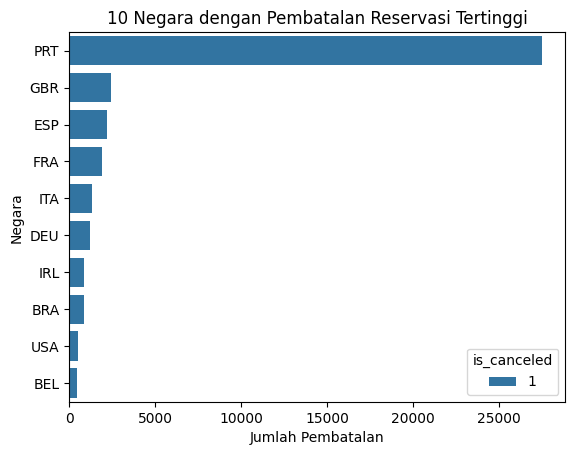

In [ ]:
# Membuat stacked bar chart
sns.countplot(y="country", hue="is_canceled", data=canceled_data, order=top10_country_canceled['country'])
plt.title("10 Negara dengan Pembatalan Reservasi Tertinggi")
plt.xlabel("Jumlah Pembatalan")
plt.ylabel("Negara")
plt.show()

In [ ]:
# Menganalisis asal negara yang tidak melakukan pembatalan reservasi tertinggi (10 teratas)
nocanceled_data=df_eda[df_eda["is_canceled"] == 0]
top10_country_nocanceled=nocanceled_data.groupby("country")["is_canceled"].count().sort_values(ascending=False)[:10].reset_index(name="total")
top10_country_nocanceled

country  total
0     PRT  20976
1     GBR   9666
2     FRA   8468
3     ESP   6383
4     DEU   6067
5     IRL   2542
6     ITA   2428
7     BEL   1868
8     NLD   1716
9     USA   1592

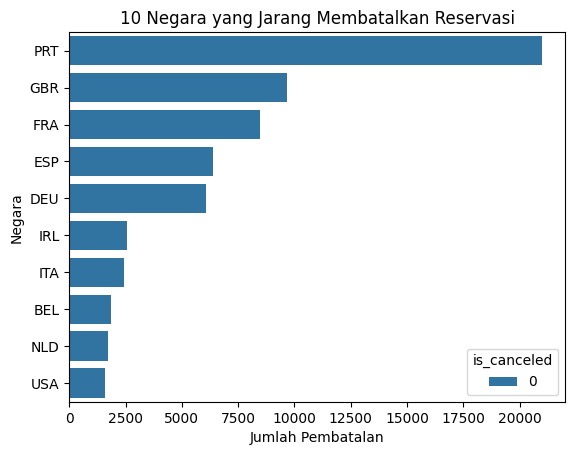

In [ ]:
# Membuat stacked bar chart
sns.countplot(y="country", hue="is_canceled", data=nocanceled_data, order=top10_country_nocanceled['country'])
plt.title("10 Negara yang Jarang Membatalkan Reservasi")
plt.xlabel("Jumlah Pembatalan")
plt.ylabel("Negara")
plt.show()

- Analisis Jumlah Pembatalan yang disebabkan akibat perubahan kamar yang di pesan

In [ ]:
# Membuat kolom baru 'different_room_reserved' untuk menunjukkan perbedaan (Per bulan-tahun)
df_eda['different_room_reserved'] = df_eda['reserved_room_type'] != df_eda['assigned_room_type']

# Melakukan Label Encoding pada kolom 'different_room_reserved'
df_eda['different_room_reserved'] = df_eda['different_room_reserved'].map({True: 1, False: 0})

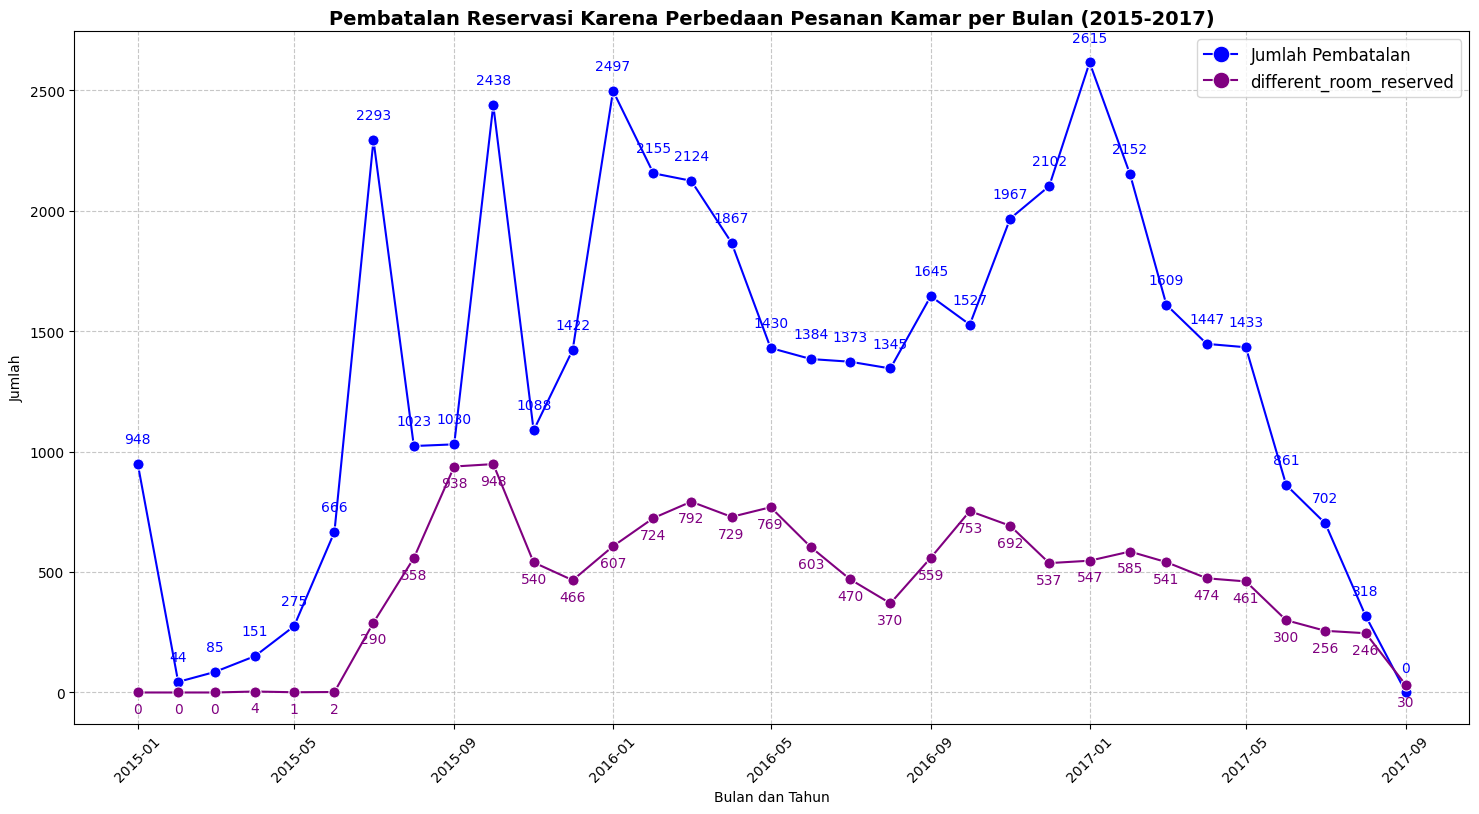

In [ ]:
# Tren pembatalan reservasi hotel July2015 - August2017 + ADR
# Filter data untuk tahun 2015-2017
df_edafilter2 = df_eda[(df_eda['reservation_status_date_year'] >= 2015) & (df_eda['reservation_status_date_year'] <= 2017)]

# Hitung jumlah pembatalan dan rata-rata pendapatan (ADR) per bulan
df_monthly2 = df_edafilter2.groupby('month_year').agg({'is_canceled': 'sum', 'different_room_reserved': 'sum'}).reset_index() # Mengubah 'count' menjadi 'sum' untuk menjumlahkan nilai 'different_room_reserved'

# Konversi 'month_year' ke datetime
df_monthly2['month_year'] = pd.to_datetime(df_monthly2['month_year'], format='%Y-%m')

# Urutkan data berdasarkan 'month_year'
df_monthly2 = df_monthly2.sort_values(by='month_year')

# Set 'month_year' sebagai index
df_monthly2.set_index('month_year', inplace=True)

# Buat line chart
plt.figure(figsize=(18,9))
sns.lineplot(x='month_year', y='is_canceled', data=df_monthly2, label='Jumlah Pembatalan', marker='o', markersize=8, color='blue') # Menggunakan df_monthly2 sebagai sumber data
sns.lineplot(x='month_year', y='different_room_reserved', data=df_monthly2, label='different_room_reserved', marker='o', markersize=8, color='purple') # Menggunakan df_monthly2 sebagai sumber data

# Anotasi untuk jumlah pembatalan
for i, row in df_monthly2.iterrows(): # Changed df_monthly to df_monthly2
    plt.annotate(f'{row["is_canceled"]}',
                 xy=(row.name, row['is_canceled']),
                 xytext=(0, 15), textcoords='offset points', ha='center',
                 color='blue') # Sesuaikan warna dengan warna garis

# Anotasi untuk Pemesanan Kamar
for i, row in df_monthly2.iterrows(): # Changed df_monthly to df_monthly2
    plt.annotate(f'{row["different_room_reserved"]}',
                 xy=(row.name, row['different_room_reserved']),
                 xytext=(0, -15), textcoords='offset points', ha='center',
                 color='purple') # Sesuaikan warna dengan warna garis

plt.grid(linestyle='--', alpha=0.7)

plt.title('Pembatalan Reservasi Karena Perbedaan Pesanan Kamar per Bulan (2015-2017)', fontsize=14, pad=5, loc='center', fontweight='bold')
plt.xlabel('Bulan dan Tahun')
plt.ylabel('Jumlah')
plt.xticks(rotation=45)
plt.legend(loc='upper right', fontsize=12, markerscale=1.5)
plt.show()

**Perbedaan Kamar yang Dipesan:** dari hasil grafik ini menunjukkan nilai yang cenderung stabil meskipun dalam periode tertentu terdapat nilai kedua titik saling berdekatan. Ini membuktikan bahwa pada periode tertentu ketika terjadi pembatalan reservasi mayoritas salah satu penyebabnya ialah adanya perubahan kamar yang dipesan. Hal ini terkadang disebabkan tipe kamar yang ditetapkan berbeda dari tipe kamar yang dipesan karena alasan operasional hotel (misalnya pemesanan berlebih atau ketidaksesuaian fasilitas yang disediakan dengan jumlah tamu dalam satu kamar) atau atas permintaan tamu.

- Analisis Jumlah Pembatalan berdasarkan riwayat pemesanan sebelumnya

In [ ]:
df_eda['previous_booking_category'] = pd.cut(df['previous_bookings_not_canceled'], bins=[0, 10, 20, np.inf], labels=['0-10', '11-20', '21+'])

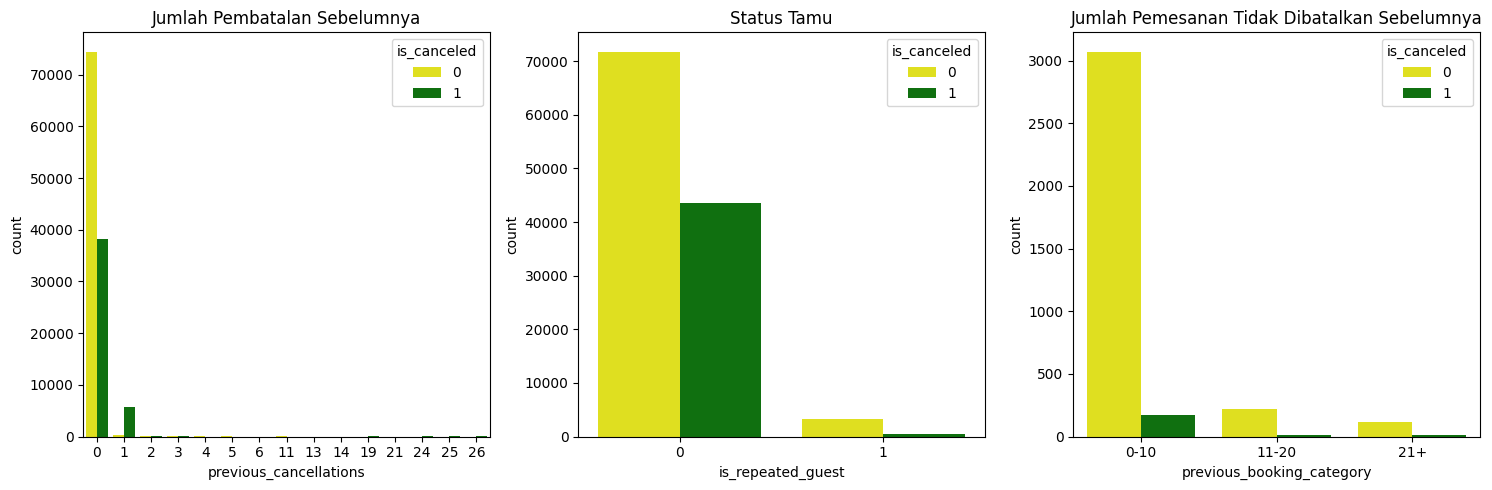

In [ ]:
# Membuat subplot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot distribusi untuk setiap variabel
sns.countplot(x='previous_cancellations', hue='is_canceled', data=df_eda, palette=colors, ax=axes[0])
axes[0].set_title('Jumlah Pembatalan Sebelumnya')

sns.countplot(x='is_repeated_guest', hue='is_canceled', data=df_eda, palette=colors, ax=axes[1])
axes[1].set_title('Status Tamu')

sns.countplot(x='previous_booking_category', hue='is_canceled', data=df_eda, palette=colors, ax=axes[2])
axes[2].set_title('Jumlah Pemesanan Tidak Dibatalkan Sebelumnya')

# Menyesuaikan tampilan
plt.tight_layout()
plt.show()

Berdasarkan hasil analisis ini, dapat dilihat melalui riwayat pemesanan sebelumnya bahwa lebih banyak tamu yang melakukan pembatalan reservasi merupakan tamu baru. Hal ini dijelaskan melalui jumlah tamu yang bukan is_repeated_guest masih sangat banyak. Potensi yang ada juga memungkinkan pihak hotel untuk mulai merencanakan pelayanan yang lebih baik apabila tamu tersebut kembali lagi menggunakan layanan hotel yang sama.

- Analisis Jumlah Pembatalan melalui pemesanan lewat agen perjalanan yang dilakukan sendiri oleh klien

In [ ]:
# Menganalisis asal agent yang melakukan pembatalan reservasi tertinggi (10 teratas)
top10_agent_canceled=canceled_data.groupby("agent")["is_canceled"].sum().sort_values(ascending=False).reset_index(name="total").iloc[:10]
top10_agent_canceled

agent  total
0    9.0  13262
1  240.0   5484
2    1.0   5279
3    0.0   4015
4    6.0   1025
5   19.0    775
6    3.0    771
7   37.0    717
8   14.0    652
9   29.0    546

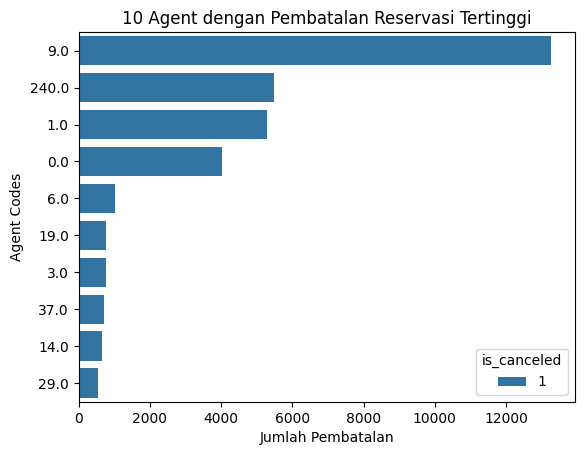

In [ ]:
# Membuat stacked bar chart
sns.countplot(y="agent", hue="is_canceled", data=canceled_data, order=top10_agent_canceled['agent'])
plt.title("10 Agent dengan Pembatalan Reservasi Tertinggi")
plt.xlabel("Jumlah Pembatalan")
plt.ylabel("Agent Codes")
plt.show()

Dapat diperhatikan bahwa terdapat beberapa pemesanan yang melalui agent terjadi pembatalan. Hal ini bisa saja disebabkan adanya kesalahan maupun kurang efektifnya sistem administrasi dan komunikasi antara pihak agent (pihak ketiga dimana klien dapat melakukan reservasi) dengan pihak hotel. Adapun pihak agent mungkin kurang dalam menarik minat klien, kurangnya pelayanan ataupun komunikasi yang personal untuk memastikan informasi yang diberikan agar meningkatkan potensi klien untuk tidak membatalkan reservasi yang telah dilakukan. Sama halnya dengan pihak agent, pada pihak hotel juga mendapati adanya klien yang melakukan reservasi langsung (agent=0) membatalkan reservasinya.

- Analisis Jumlah Pembatalan melalui pemesanan lewat perusahaan

In [ ]:
# Menganalisis asal agent yang melakukan pembatalan reservasi tertinggi (10 teratas)
top10_company_canceled=canceled_data.groupby("company")["is_canceled"].sum().sort_values(ascending=False).reset_index(name="total").iloc[:11]
top10_company_canceled

company  total
0       0.0  43016
1      67.0    175
2     223.0    119
3      40.0     77
4     348.0     59
5     153.0     48
6     202.0     38
7     197.0     35
8      51.0     35
9     385.0     30
10     45.0     28

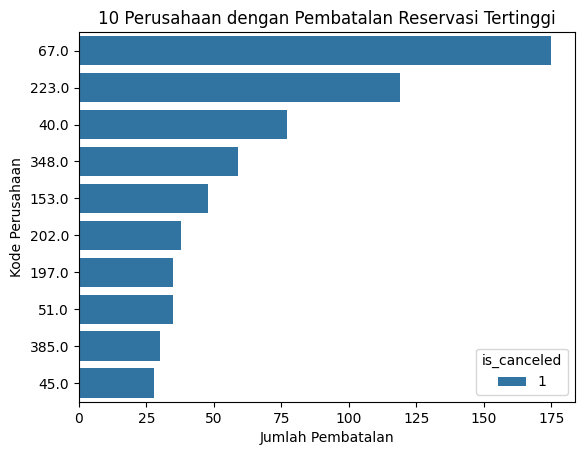

In [ ]:
# Tidak perlu menampilkan hasil company = 0 (reservasi mandiri)
top10_company_canceled = top10_company_canceled[top10_company_canceled['company'] != 0.0]

# Membuat stacked bar chart
sns.countplot(y="company", hue="is_canceled", data=canceled_data, order=top10_company_canceled['company'])
plt.title("10 Perusahaan dengan Pembatalan Reservasi Tertinggi")
plt.xlabel("Jumlah Pembatalan")
plt.ylabel("Kode Perusahaan")
plt.show()

Dari hasil ini sudah dapat terlihat bahwasannya dalam periode Juli 2015 hingga Agustus 2017 ini, pihak perusahaan telah melakukan beberapa kali pembatalan meskipun tidak seburuk klien yang melakukan reservasi secara mandiri.

- Analisis Jumlah Pembatalan berdasarkan jaminan/deposit yang telah diberikan klien ke pihak hotel

In [ ]:
# Jumlah pembatalan berdasarkan channel distribusi
cancel_deposit = df_eda.groupby('deposit_type')['is_canceled'].value_counts()
cancel_deposit

deposit_type  is_canceled
No Deposit    0              74787
              1              29668
Non Refund    1              14493
              0                 93
Refundable    0                126
              1                 36
Name: count, dtype: int64

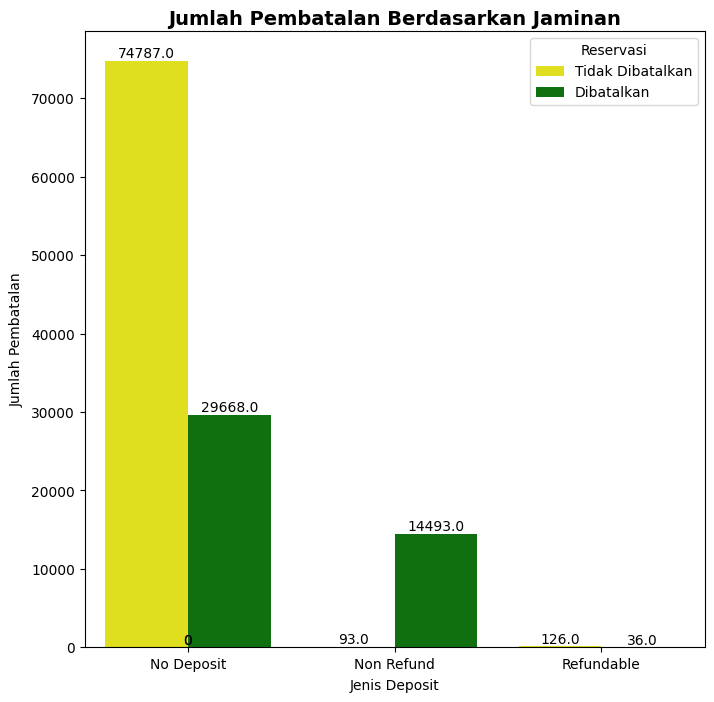

In [ ]:
plt.figure(figsize=(8,8))
sns.countplot(x='deposit_type', hue='is_canceled', data=df_eda, palette=colors, order=df_eda['deposit_type'].value_counts().index)
plt.title('Jumlah Pembatalan Berdasarkan Jaminan', fontsize=14, pad=5, loc='center', fontweight='bold')
plt.xlabel('Jenis Deposit', labelpad=5)
plt.ylabel('Jumlah Pembatalan', labelpad=5)
plt.legend(title='Reservasi', labels=labels, loc='upper right')
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5),
                textcoords='offset points')
plt.show()

Berdasarkan hasil grafik, tamu yang tidak memberikan jaminan sebelumnya lebih cenderung melakukan pembatalan reservasi. Sedangkan pada tamu yang telah menyertakan jaminan cenderung lebih jarang melakukan pembatalan reservasi. Sedangkan untuk jenis deposit yang paling jarang digunakan adalah `Refundable`.

- Analisis Jumlah Pembatalan berdasarkan fasilitas dari pihak hotel yang telah di pesan oleh tamu

In [ ]:
# Buat dictionary mapping
meal_mapping = {'With Meal': 1, 'No Meal': 0}

df_eda['meal'] = df_eda['meal'].map(meal_mapping)

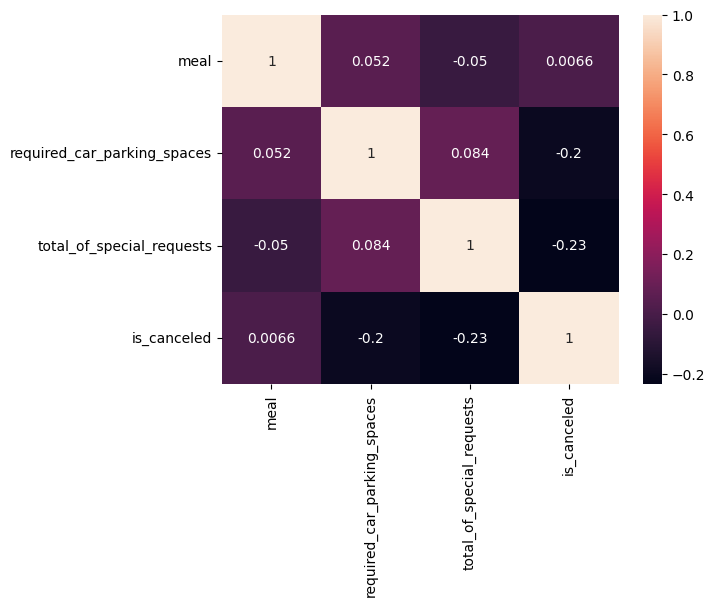

In [ ]:
# Hitung matriks korelasi
corr_matrix_fc = df_eda[['meal', 'required_car_parking_spaces', 'total_of_special_requests','is_canceled']].corr()

# Visualisasi menggunakan heatmap
sns.heatmap(corr_matrix_fc, annot=True)
plt.show()

In [ ]:
def create_guest_category(row):
    if row['meal'] == 0 and row['required_car_parking_spaces'] == 0 and row['total_of_special_requests'] < 1:
        return 'Basic Traveler'
    elif row['meal'] == 1 and row['required_car_parking_spaces'] == 0 and row['total_of_special_requests'] < 1:
        return 'Simple Meal'
    elif row['meal'] == 1 and row['required_car_parking_spaces'] >= 1 and row['total_of_special_requests'] < 1:
        return 'Parking Required'
    elif row['meal'] == 1 and row['required_car_parking_spaces'] >= 1 and row['total_of_special_requests'] >= 1:
        return 'High-Maintenance'
    elif row['meal'] == 1 and row['required_car_parking_spaces'] == 0 and row['total_of_special_requests'] >= 1:
        return 'Special Requests'
    elif row['meal'] == 0 and row['required_car_parking_spaces'] >= 1 and row['total_of_special_requests'] >= 1:
        return 'Parking & Special Requests'
    elif row['meal'] == 0 and row['required_car_parking_spaces'] == 0 and row['total_of_special_requests'] >= 1:
        return 'Minimalist with Requests'
    elif row['meal'] == 0 and row['required_car_parking_spaces'] >= 1 and row['total_of_special_requests'] < 1:
        return 'Parking Only'
    else:
        return 'Other'

df_eda['guest_category'] = df_eda.apply(create_guest_category, axis=1)

Berikut ini beberapa nama kategori yang lebih deskriptif berdasarkan fiturnya:

- **Kategori 1: Basic Traveler** (Tanpa makanan, Tanpa parkir, Tanpa permintaan khusus)
- **Kategori 2: Simple Meal** (Makanan, Tanpa parkir, Tanpa permintaan khusus)
- **Kategori 3: Parking Required** (Makanan, Parkir, Tanpa permintaan khusus)
- **Kategori 4: High-Maintenance** (Makanan, Parkir, Permintaan khusus)
- **Kategori 5: Special Requests** (Makanan, Tanpa parkir, Permintaan khusus)
- **Kategori 6: Parking & Special Requests** (Tanpa makanan, Parkir, Permintaan khusus)
- **Kategori 7: Minimalist with Requests** (Tanpa makanan, Tanpa parkir, Permintaan khusus)
- **Kategori 8: Parking Only** (Tanpa makanan, Parkir, Tanpa permintaan khusus)
- **Kategori 9: Other** (Untuk kombinasi apa pun yang tidak tercakup dalam kategori yang ditentukan)

Penjelasan Nama Kategori:

1. Basic Traveler: Mewakili tamu dengan kebutuhan paling dasar, yang tidak memerlukan layanan tambahan.
2. Simple Meal: Tamu yang memerlukan makanan tetapi tidak memiliki permintaan khusus lainnya.
3. Parking Required: Tamu yang memerlukan tempat parkir tetapi tidak memiliki permintaan khusus atau persyaratan makanan lainnya.
4. High-Maintenance: Tamu dengan ekspektasi tinggi, memerlukan makanan, tempat parkir, dan permintaan khusus tambahan.
5. Special Requests: Tamu dengan permintaan khusus tetapi tidak memerlukan tempat parkir atau makanan.
6. Parking & Special Requests: Tamu yang memerlukan tempat parkir dan memiliki permintaan khusus tambahan.
7. Minimalist with Requests: Tamu yang memiliki permintaan khusus tetapi tidak memerlukan makanan atau tempat parkir.
8. Parking Only: Tamu yang hanya memerlukan tempat parkir.
9. Other: Kategori umum untuk kombinasi fitur apa pun yang tidak didefinisikan secara eksplisit.

In [ ]:
df_eda['guest_category'].value_counts()

guest_category
Simple Meal                   61544
Special Requests              38811
Minimalist with Requests       5935
Basic Traveler                 5506
High-Maintenance               4073
Parking Required               3057
Parking & Special Requests      187
Parking Only                     90
Name: count, dtype: int64

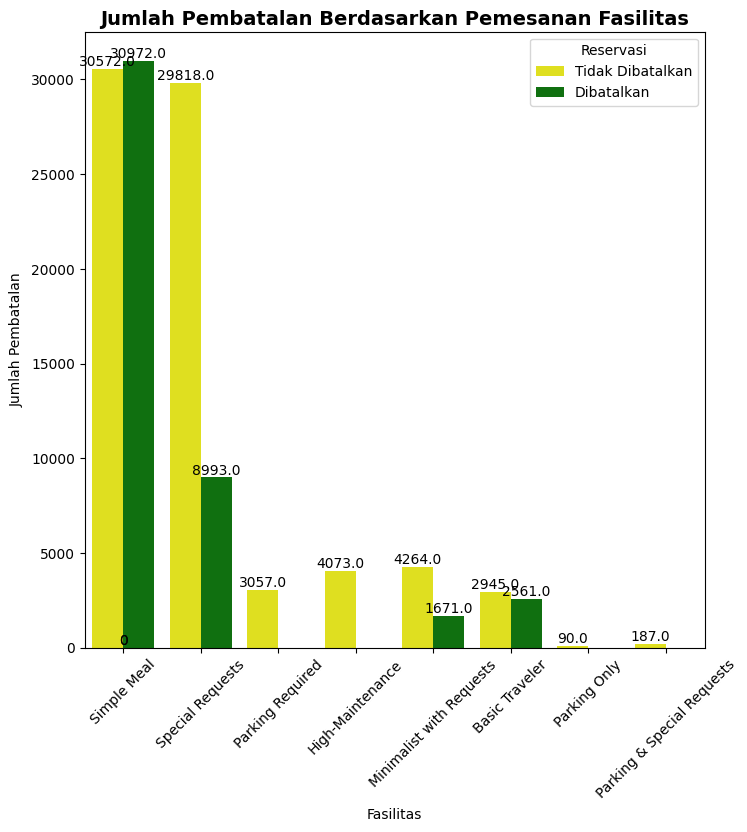

In [ ]:
# Analisis pembatalan
plt.figure(figsize=(8,8))
pd.crosstab(df_eda['guest_category'], df_eda['is_canceled'], normalize='index') * 100
sns.countplot(x='guest_category', hue='is_canceled', data=df_eda, palette=colors)
plt.title('Jumlah Pembatalan Berdasarkan Pemesanan Fasilitas', fontsize=14, pad=5, loc='center', fontweight='bold')
plt.xlabel('Fasilitas', labelpad=5)
plt.ylabel('Jumlah Pembatalan', labelpad=5)
plt.legend(title='Reservasi', labels=labels, loc='upper right')
plt.xticks(rotation=45)

ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5),
                textcoords='offset points')

plt.show()

Berdasarkan kategori pemesanan fasilitas oleh tamu, lebih banyak di `Simple Meal` (Hanya paket makanan) begitu juga jumlah pembatalan yang terjadi pada kategori ini termasuk yang paling tinggi. Dari hasil ini juga bisa dikatakan bahwa ketika tamu yang membutuhkan lahan parkir `required_car_parking_spaces` lebih cenderung tidak akan membatalkan reservasi.

Dan pada tingkat pemesanan/reservasi lebih didominasi oleh tamu kategori `Simple Meal` dan `Special Request` yang mana lebih mengutamakan paket makanan dan layanan spesial yang disediakan oleh hotel.

## Feature Engineering

In [ ]:
df2 = df_clean.copy()

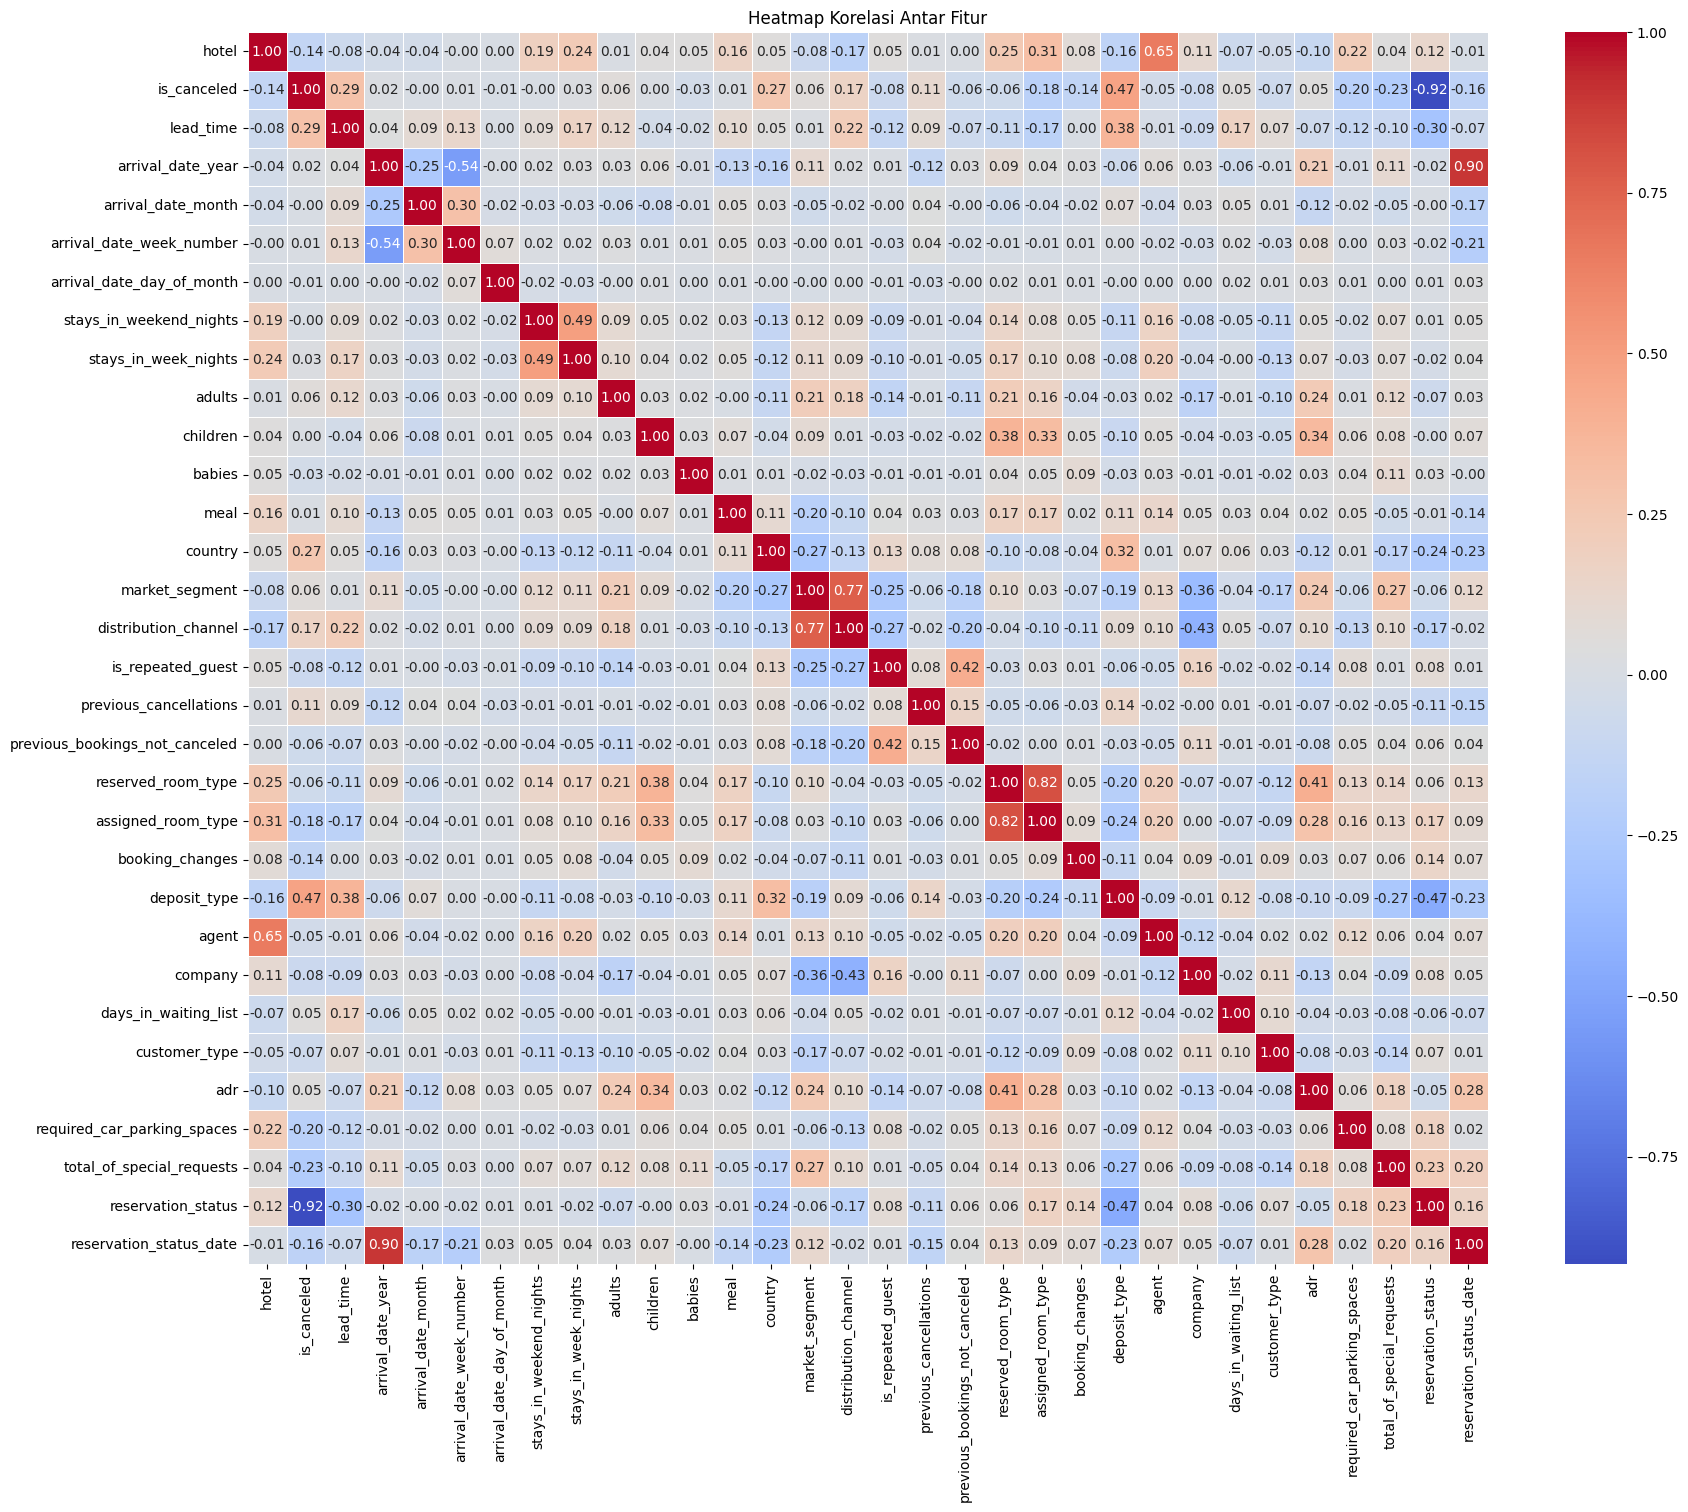

In [ ]:
# 1. Menentukan kolom yang memiliki data non-numerik
non_numerical_columns = df2.select_dtypes(include=['object']).columns

# 2. Melakukan Label Encoding pada setiap kolom non-numerik
label_encoder = LabelEncoder()
for col in non_numerical_columns:
    df2[col] = label_encoder.fit_transform(df2[col])

# 3. Menghitung Matriks Korelasi
# Korelasi hanya dapat dihitung pada data numerik
correlation_matrix = df2.corr()

# 4. Membuat Heatmap
plt.figure(figsize=(20, 16))  # Menentukan ukuran gambar heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Menambahkan judul
plt.title('Heatmap Korelasi Antar Fitur')

# Menampilkan heatmap
plt.show()

**Memahami Heatmap Korelasi**

Heatmap korelasi adalah visualisasi yang menunjukkan kekuatan dan arah hubungan antara variabel-variabel dalam suatu dataset. Warna pada heatmap merepresentasikan tingkat korelasi:

- Warna merah: Korelasi positif yang kuat (semakin merah, semakin kuat hubungan positifnya).
- Warna biru: Korelasi negatif yang kuat (semakin biru, semakin kuat hubungan negatifnya).
- Warna putih: Tidak ada korelasi atau korelasi yang sangat lemah.
Analisis Heatmap Korelasi untuk is_canceled

Fokus pada baris dan kolom yang terkait dengan is_canceled (TARGET). Berikut beberapa wawasan yang dapat kita tarik:

**Korelasi Positif:**
- lead_time: Semakin lama waktu antara pemesanan dan tanggal kedatangan, semakin tinggi kemungkinan pembatalan. Ini menunjukkan bahwa tamu yang memesan jauh-jauh hari cenderung lebih mudah membatalkan reservasi.
- previous_cancellations: Tamu yang memiliki riwayat pembatalan sebelumnya cenderung lebih sering membatalkan reservasi di masa depan.
- required_car_parking_spaces: Tamu yang membutuhkan tempat parkir cenderung lebih sering membatalkan reservasi. Ini bisa jadi karena terbatasnya ketersediaan tempat parkir atau karena adanya perubahan rencana perjalanan.

**Korelasi Negatif:**
- is_repeated_guest: Tamu yang pernah menginap sebelumnya cenderung lebih jarang membatalkan reservasi. Ini menunjukkan bahwa tamu yang loyal memiliki tingkat loyalitas yang lebih tinggi.
- total_of_special_requests: Tamu yang memiliki banyak permintaan khusus cenderung lebih jarang membatalkan reservasi. Ini mungkin karena hotel telah berusaha memenuhi permintaan khusus mereka, sehingga tamu merasa lebih terikat dengan reservasi.

**Wawasan Lainnya**
- Variabel yang Kurang Berpengaruh: Sebagian besar variabel lainnya memiliki korelasi yang sangat lemah atau tidak ada korelasi dengan is_canceled. Ini menunjukkan bahwa variabel-variabel tersebut mungkin tidak memiliki pengaruh signifikan terhadap keputusan tamu untuk membatalkan reservasi.
- Interaksi Antar Variabel: Heatmap juga dapat menunjukkan interaksi antara variabel-variabel. Misalnya, mungkin ada interaksi antara lead_time dan is_repeated_guest, di mana pengaruh lead_time terhadap pembatalan berbeda untuk tamu yang sering dan jarang menginap.

### Feature Multicollinearity Correction

In [ ]:
# Split dataset: Train-Test (80:20)
feature = df2.drop(columns='is_canceled')
target = df2[['is_canceled']]

feature_df_train, feature_df_test, target_df_train, target_df_test = train_test_split(feature, target, test_size=0.20, random_state=42) # membagi data dengan perbandingan data training : testing (80:20)

In [ ]:
# Check VIF Score
X = add_constant(feature_df_train)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

feature  vif_score
1                            hotel   2.357074
2                        lead_time   1.879051
3                arrival_date_year  35.529342
4               arrival_date_month   1.151158
5         arrival_date_week_number   6.199483
6        arrival_date_day_of_month   1.011614
7          stays_in_weekend_nights   1.376763
8             stays_in_week_nights   1.464846
9                           adults   1.191824
10                        children   1.260636
11                          babies   1.025801
12                            meal   1.166871
13                         country   1.291620
14                  market_segment   3.615779
15            distribution_channel   3.439053
16               is_repeated_guest   1.329875
17          previous_cancellations   1.079010
18  previous_bookings_not_canceled   1.266525
19              reserved_room_type   3.714052
20              assigned_room_type   3.444245
21                 booking_changes   1.072921
22                    deposit_type   1.924097
23                           agent   2.034078
24                         company   1.310797
25            days_in_waiting_list   1.065935
26                   customer_type   1.202024
27                             adr   1.653848
28     required_car_parking_spaces   1.113993
29       total_of_special_requests   1.266673
30              reservation_status   1.885178
31         reservation_status_date  26.956271

**Hasil cek korelasi antar fitur (> 0.7 threshold):**
- is_canceled dan reservation_status (-0.92)
- arrival_date_year dan reservation_status_date (0.90)
- market_segment dan distribution_channel	(0.77)
- reserved_room_type dan assigned_room_type	(0.82)

**Hasil nilai vif score (> 5.0 threshold):**
- arrival_date_year (35.529342)
- arrival_date_week_number (6.199483)
- reservation_status_date (26.956271)

**Perimbangan langkah lanjutan menangani multikolinearitas:**
1. **Menghapus Fitur Redundan:** Dalam project ini saya bertujuan membangun model ml guna mencari dan memprediksi tamu yang berkemungkinan melakukan pembatalan reservasi hotel. Mungkin jika untuk mengidentifikasi faktor mengapa terjadi pembatalan reservasi berdasarkan dataset yang ada, kolom reservation_status memiliki informasi yang lebih kaya dengan adanya multi-kelas (lebih dari dua kelas). Namun, disini saya memutuskan untuk **menghapus kolom reservation_status** yang menyajikan informasi serupa dengan target is_canceled meski dalam bentuk yang berbeda. Maka saya **pertahankan is_canceled sebagai variabel target model ml** untuk memprediksi pembatalan reservasi. Kemudian saya memutuskan untuk **menghapus kolom fitur data privasi tamu seperti name, email, phone-number dan credit_card** sebelumnya karena dalam project ini saya tidak melakukan segmentasi dan saya menganggap keempat fitur ini tidak relevan untuk model prediksi sehingga bisa dihapus.

2. **Mengkombinasikan Fitur:** Membentuk fitur baru guna mencari 'waktu pemesanan', 'lama waktu tinggal', 'musim pembatalan', dll dengan kombinasi antara fitur-fitur yang mewakili tanggal (date) baik kedatangan (arrival), status_reservasi_date (canceled or check-out). Diharapkan bisa mengurangi fitur yang tidak perlu dan menghasilkan fitur yang lebih relevan.

3. **Pengurangan Dimensi:** Jika masih banyak fitur yang berkorelasi, maka akan dipertimbangkan untuk mengurangi dimensi dataset dengan PCA maupun FA.

4. **Seleksi Fitur:** Memilih fitur yang berkorelasi tinggi dengan variabel target is_canceled karena dianggap memberikan informasi yang lebih relevan.

5. **Analisis lebih lanjut:** menggunakan visualisasi seperti scatter plot atau pair plot untuk melihat hubungan antar fitur secara lebih detail serta pemahaman mendalam seputar bisnis perhotelan.

### Feature Selection

In [ ]:
df3 = df_clean.copy()

In [ ]:
df3 = df3.drop(columns=['reservation_status']) # menghapus fitur redundan  yang sama dengan target
df3 = df3.drop(columns=['arrival_date_year']) # menghapus fitur redundan  yang sama dengan 'arrival_date_month' dan 'arrival_date_week_number'
df3 = df3.drop(columns=['market_segment']) # menghapus fitur redundan  yang sama dengan 'distribution_channel'
df3 = df3.drop(columns=['reserved_room_type']) # menghapus fitur redundan  yang sama dengan 'assigned_room_type'

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119203 entries, 0 to 119389
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119203 non-null  object 
 1   is_canceled                     119203 non-null  int64  
 2   lead_time                       119203 non-null  int64  
 3   arrival_date_month              119203 non-null  object 
 4   arrival_date_week_number        119203 non-null  int64  
 5   arrival_date_day_of_month       119203 non-null  int64  
 6   stays_in_weekend_nights         119203 non-null  int64  
 7   stays_in_week_nights            119203 non-null  int64  
 8   adults                          119203 non-null  int64  
 9   children                        119203 non-null  int64  
 10  babies                          119203 non-null  int64  
 11  meal                            119203 non-null  object 
 12  country              

Awalnya dari dataset dengan **36 kolom fitur menjadi 28 kolom fitur**

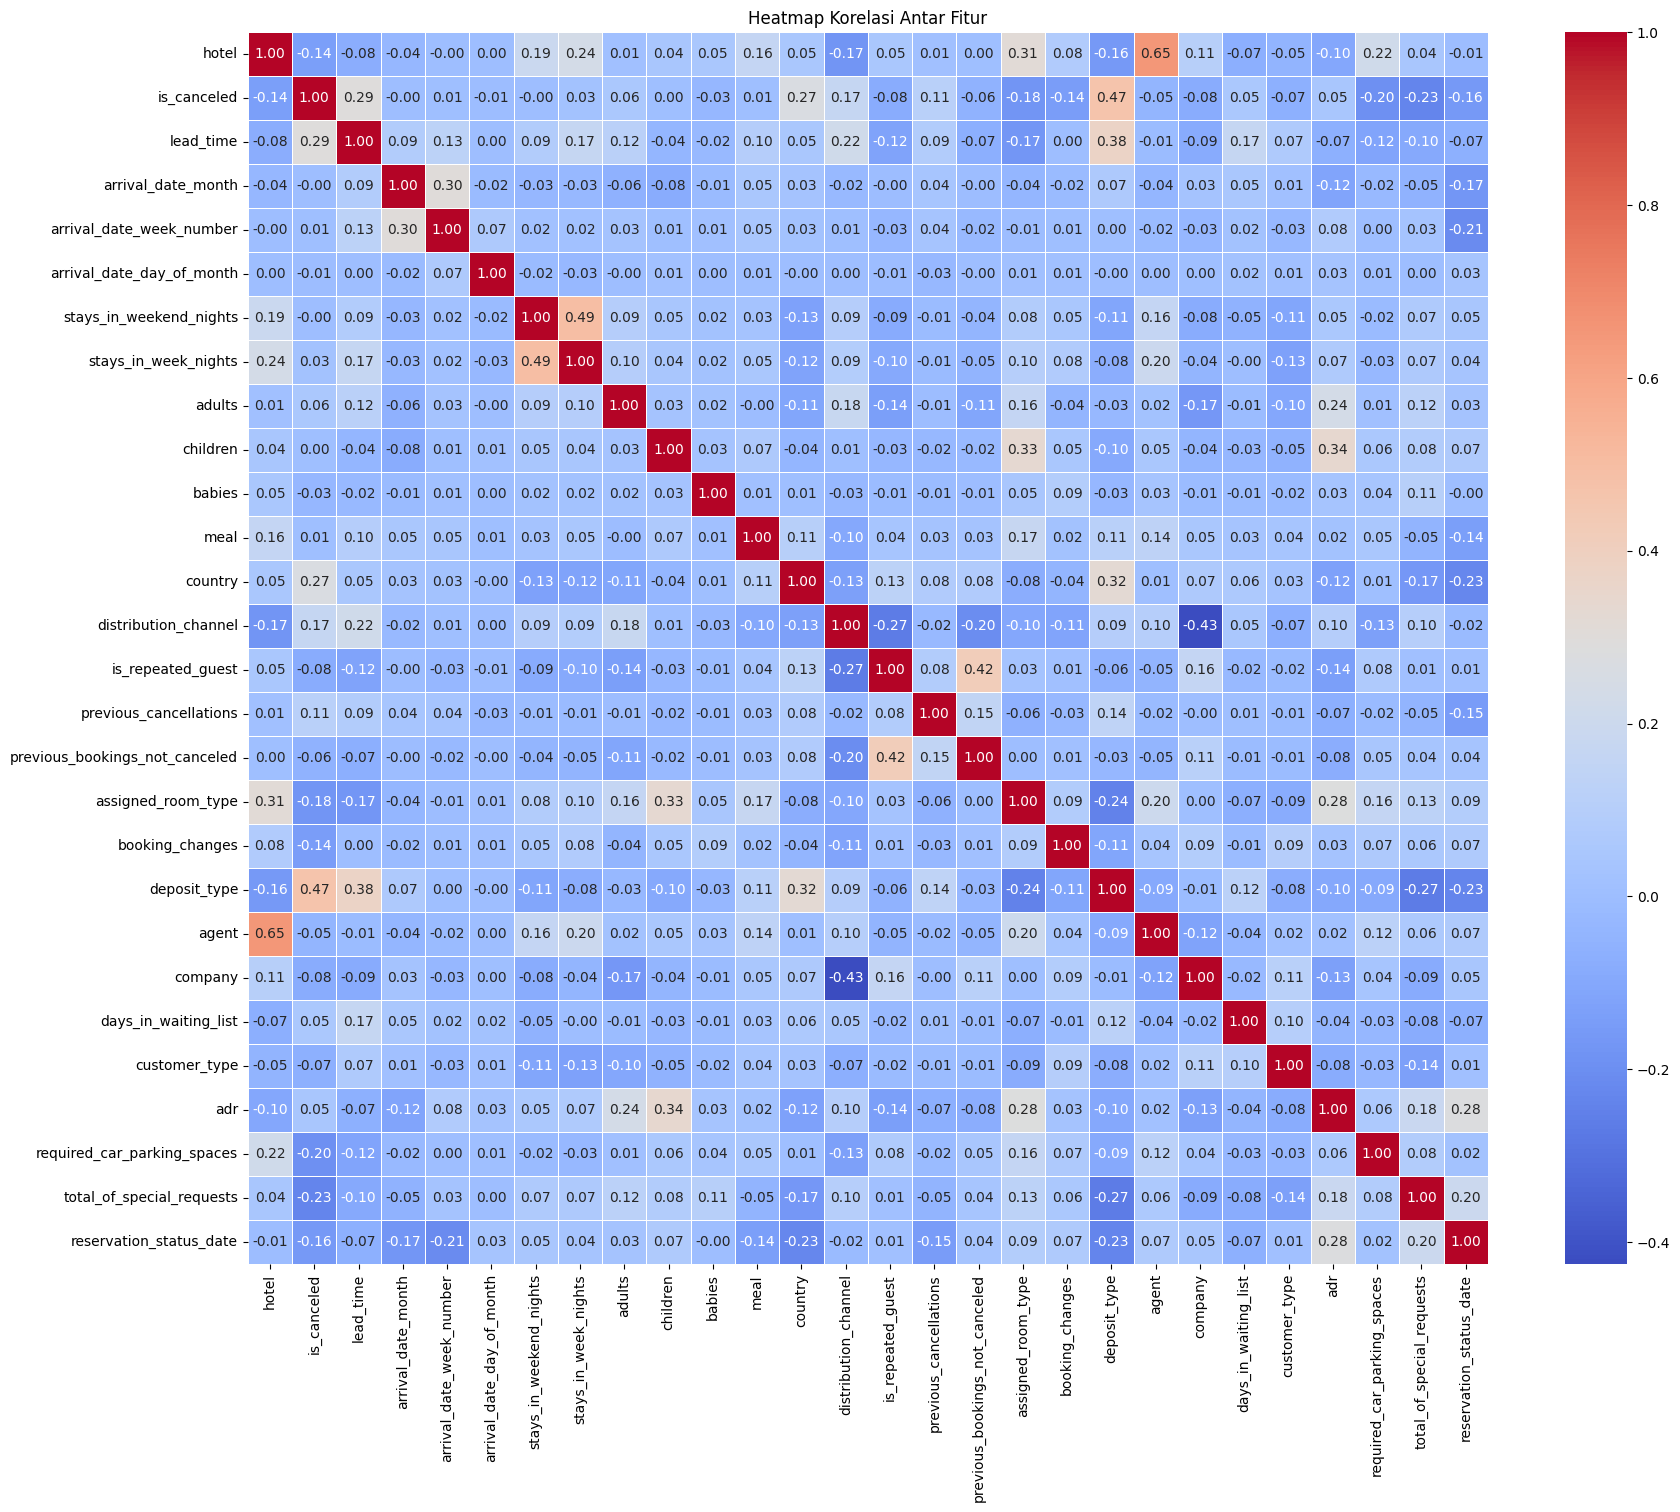

In [ ]:
# Periksa kembali multikolinearitas
# 1. Menentukan kolom yang memiliki data non-numerik
non_numerical_columns = df3.select_dtypes(include=['object']).columns

# 2. Melakukan Label Encoding pada setiap kolom non-numerik
label_encoder = LabelEncoder()
for col in non_numerical_columns:
    df3[col] = label_encoder.fit_transform(df3[col])

# 3. Menghitung Matriks Korelasi
# Korelasi hanya dapat dihitung pada data numerik
correlation_matrix = df3.corr()

# 4. Membuat Heatmap
plt.figure(figsize=(20, 16))  # Menentukan ukuran gambar heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

# Menambahkan judul
plt.title('Heatmap Korelasi Antar Fitur')

# Menampilkan heatmap
plt.show()

Dapat diperhatikan bahwa sudah tidak ada fitur yang berkorelasi tinggi. **(Threshold > 0.7)**

In [ ]:
feature = df3.drop(columns='is_canceled')
target = df3[['is_canceled']]

feature_df_train, feature_df_test, target_df_train, target_df_test = train_test_split(feature, target, test_size=0.20, random_state=42) # membagi data dengan perbandingan data training : testing (80:20)

In [ ]:
# Periksa kembali VIF Score
X = add_constant(feature_df_train)

vif_df = pd.DataFrame([vif(X.values, i)
               for i in range(X.shape[1])],
              index=X.columns).reset_index()
vif_df.columns = ['feature','vif_score']
vif_df = vif_df.loc[vif_df.feature!='const']
vif_df

feature  vif_score
1                            hotel   2.354814
2                        lead_time   1.419401
3               arrival_date_month   1.148846
4         arrival_date_week_number   1.214565
5        arrival_date_day_of_month   1.011057
6          stays_in_weekend_nights   1.367421
7             stays_in_week_nights   1.452301
8                           adults   1.181927
9                         children   1.239848
10                          babies   1.024632
11                            meal   1.131547
12                         country   1.238041
13            distribution_channel   1.507914
14               is_repeated_guest   1.319208
15          previous_cancellations   1.074605
16  previous_bookings_not_canceled   1.266063
17              assigned_room_type   1.461124
18                 booking_changes   1.063293
19                    deposit_type   1.571319
20                           agent   2.028317
21                         company   1.306246
22            days_in_waiting_list   1.054250
23                   customer_type   1.144876
24                             adr   1.502919
25     required_car_parking_spaces   1.095877
26       total_of_special_requests   1.195263
27         reservation_status_date   1.349755

Hasil VIF Score menunjukkan tidak ada korelasi yang tinggi antar-fitur **(Treshold > 5.0)**. Maka hasil dataset ini bisa diproses ke dalam model.

## Model Training

Model yang akan digunakan dalam analisis:
- Logistic Regression (Based Model)
- Decision Tree
- Random Forest
- Support Vector Machine (SVM)
- Neural Network (MLP)
- XGBoost
- LightGBM

In [ ]:
df_manual = df_clean.copy()

In [ ]:
df_manual = df_manual.drop(columns=['reservation_status']) # menghapus fitur redundan  yang sama dengan target
df_manual = df_manual.drop(columns=['arrival_date_year']) # menghapus fitur redundan  yang sama dengan 'arrival_date_month' dan 'arrival_date_week_number'
df_manual = df_manual.drop(columns=['market_segment']) # menghapus fitur redundan  yang sama dengan 'distribution_channel'
df_manual = df_manual.drop(columns=['reserved_room_type']) # menghapus fitur redundan  yang sama dengan 'assigned_room_type'

In [ ]:
df_manual.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119203 entries, 0 to 119389
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119203 non-null  object 
 1   is_canceled                     119203 non-null  int64  
 2   lead_time                       119203 non-null  int64  
 3   arrival_date_month              119203 non-null  object 
 4   arrival_date_week_number        119203 non-null  int64  
 5   arrival_date_day_of_month       119203 non-null  int64  
 6   stays_in_weekend_nights         119203 non-null  int64  
 7   stays_in_week_nights            119203 non-null  int64  
 8   adults                          119203 non-null  int64  
 9   children                        119203 non-null  int64  
 10  babies                          119203 non-null  int64  
 11  meal                            119203 non-null  object 
 12  country              

In [ ]:
df_manual.isna().sum().sum()

np.int64(0)

### Categorical Encoding

In [ ]:
# Split Data

feature = df_manual.drop(columns='is_canceled')
target = df_manual[['is_canceled']]

# Separate numerical and categorical columns
categorical_cols = ['hotel', 'arrival_date_month', 'meal', 'country', 'distribution_channel', 'assigned_room_type', 'deposit_type', 'customer_type', 'reservation_status_date']
numerical_cols = ['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests']

In [ ]:
# Frequency Encoding

# Fungsi untuk frekuensi encoding
def frequency_encoding(data, categorical_cols):
    for col in categorical_cols:
        freq = data[col].value_counts(normalize=True)
        data[col + '_freq'] = data[col].map(freq)
    # Hapus kolom asli setelah encoding
    data.drop(categorical_cols, axis=1, inplace=True)
    return data

# Frekuensi encoding pada data train dan test
feature_encoded = frequency_encoding(feature, categorical_cols)

In [ ]:
feature_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 119203 entries, 0 to 119389
Data columns (total 27 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   lead_time                       119203 non-null  int64  
 1   arrival_date_week_number        119203 non-null  int64  
 2   arrival_date_day_of_month       119203 non-null  int64  
 3   stays_in_weekend_nights         119203 non-null  int64  
 4   stays_in_week_nights            119203 non-null  int64  
 5   adults                          119203 non-null  int64  
 6   children                        119203 non-null  int64  
 7   babies                          119203 non-null  int64  
 8   is_repeated_guest               119203 non-null  int64  
 9   previous_cancellations          119203 non-null  int64  
 10  previous_bookings_not_canceled  119203 non-null  int64  
 11  booking_changes                 119203 non-null  int64  
 12  agent                

### Handling Imbalanced Data

In [ ]:
# Melakukan Oversampling dengan SMOTE

smote = SMOTE(sampling_strategy='minority')
feature_res, target_res = smote.fit_resample(feature_encoded, target)

### Split Dataset: Train-Test

In [ ]:
# splitting: train and test (80:20)
feature_admit_train, feature_admit_test, target_admit_train, target_admit_test = train_test_split(feature_res, target_res, test_size=0.20, random_state=42)

feature_admit_train.shape, feature_admit_test.shape, target_admit_train.shape, target_admit_test.shape

((120009, 27), (30003, 27), (120009, 1), (30003, 1))

In [ ]:
cancel_count = target_admit_train.value_counts(normalize=True)*100
cancel_count

is_canceled
1              50.015416
0              49.984584
Name: proportion, dtype: float64

In [ ]:
cancel_count = target_admit_test.value_counts(normalize=True)*100
cancel_count

is_canceled
0              50.061661
1              49.938339
Name: proportion, dtype: float64

Diketahui bahwa data target tidak seimbang, maka kita akan menguji apakah hasil model akan lebih baik jika kita melakukan undersampling, oversamping atau tidak perlu menghandle data yang tidak seimbang.

### Standarisasi

In [ ]:
# Standarisasi

X_train = feature_admit_train
X_test = feature_admit_test

# Standarisasi pada data train
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled

array([[-1.00004627, -0.38267308,  1.1724298 , ...,  0.4476936 ,
         0.552251  ,  0.19670151],
       [ 0.54363344, -0.23410151, -0.54386702, ..., -2.2380828 ,
         0.552251  , -0.47430729],
       [ 1.59080798,  1.92018616,  1.40126937, ...,  0.4476936 ,
         0.552251  , -0.32247318],
       ...,
       [ 0.03810091, -1.27410246,  1.51568916, ..., -2.2380828 ,
         0.552251  ,  1.06852318],
       [-0.62992423,  0.50875631,  0.94359022, ...,  0.4476936 ,
         0.552251  , -0.37753217],
       [ 0.84153654, -1.27410246, -0.7727066 , ...,  0.4476936 ,
         0.552251  , -0.32157495]])

In [ ]:
X_test_scaled

array([[-0.53965057, -0.08552995,  0.94359022, ...,  0.4476936 ,
        -1.68283042, -0.42043067],
       [ 0.41725031, -0.01124417, -1.57364511, ...,  0.4476936 ,
         0.552251  , -0.59185628],
       [ 0.35405874,  1.25161412,  1.28684959, ...,  0.4476936 ,
         0.552251  , -0.26581939],
       ...,
       [-0.62089687, -0.75410199,  0.94359022, ...,  0.4476936 ,
         0.552251  , -0.3959413 ],
       [ 0.61585238, -0.60553042, -1.23038575, ..., -2.2380828 ,
         0.552251  ,  1.06852318],
       [-0.89171787,  0.954471  ,  1.28684959, ...,  0.4476936 ,
         0.552251  , -0.31757531]])

### Define Model

In [ ]:
# 1. Logistic Regression

# Membuat model Logistic Regression
logreg = LogisticRegression(random_state=42)

In [ ]:
# 2. Decision Tree

# Membuat model Decision Tree
dtree = DecisionTreeClassifier(random_state=42)

In [ ]:
# 3. Random Forest

# Membuat model Random Forest
rf = RandomForestClassifier(random_state=42)

In [ ]:
# 4. SVM

SVM = SVC() # default kernel rbf, c = 1.0

In [ ]:
# 5. Neural Network (MLP)

# Membuat model Neural Network (MLP)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)

In [ ]:
# 6. XGBoost

# Membuat model XGBoost
xgb = XGBClassifier(random_state=42)

In [ ]:
# 7. LightGBM

# Membuat model LGBoost
lgb = LGBMClassifier(random_state=42)

In [ ]:
# Mengubah bentuk kolom target menjadi array 1D
y_admit_train = target_admit_train.to_numpy()
y_admit_train = y_admit_train.reshape(len(y_admit_train),)

y_admit_test = target_admit_test.to_numpy()
y_admit_test = y_admit_test.reshape(len(y_admit_test),)

### Evaluasi tanpa Hyperparameter Tuning + Cross Validation

In [ ]:
# 1. Logistic Regression
logreg.fit(X_train_scaled, y_admit_train)
y_train1 = logreg.predict(X_train_scaled)
y_pred1 = logreg.predict(X_test_scaled)

In [ ]:
# classification report Logistic Regression
print("TRAIN LogReg:")
print(classification_report(y_admit_train, y_train1))
print("TEST LogReg:")
print(classification_report(y_admit_test, y_pred1))

TRAIN LogReg:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     59986
           1       0.81      0.76      0.78     60023

    accuracy                           0.79    120009
   macro avg       0.79      0.79      0.79    120009
weighted avg       0.79      0.79      0.79    120009

TEST LogReg:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79     15020
           1       0.80      0.76      0.78     14983

    accuracy                           0.79     30003
   macro avg       0.79      0.79      0.79     30003
weighted avg       0.79      0.79      0.79     30003



In [ ]:
# 2. Decision Tree
dtree.fit(X_train_scaled, y_admit_train)
y_train2 = dtree.predict(X_train_scaled)
y_pred2 = dtree.predict(X_test_scaled)

In [ ]:
# classification report Decision Tree
print("TRAIN DecisionTree:")
print(classification_report(y_admit_train, y_train2))
print("TEST DecisionTree:")
print(classification_report(y_admit_test, y_pred2))

TRAIN DecisionTree:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59986
           1       1.00      1.00      1.00     60023

    accuracy                           1.00    120009
   macro avg       1.00      1.00      1.00    120009
weighted avg       1.00      1.00      1.00    120009

TEST DecisionTree:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88     15020
           1       0.88      0.89      0.88     14983

    accuracy                           0.88     30003
   macro avg       0.88      0.88      0.88     30003
weighted avg       0.88      0.88      0.88     30003



In [ ]:
# 3. Random Forest
rf.fit(X_train_scaled, y_admit_train)
y_train3 = rf.predict(X_train_scaled)
y_pred3 = rf.predict(X_test_scaled)

In [ ]:
# classification report Random Forest
print("TRAIN RandomForest:")
print(classification_report(y_admit_train, y_train3))
print("TEST RandomForest:")
print(classification_report(y_admit_test, y_pred3))

TRAIN RandomForest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59986
           1       1.00      1.00      1.00     60023

    accuracy                           1.00    120009
   macro avg       1.00      1.00      1.00    120009
weighted avg       1.00      1.00      1.00    120009

TEST RandomForest:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     15020
           1       0.94      0.91      0.93     14983

    accuracy                           0.93     30003
   macro avg       0.93      0.93      0.93     30003
weighted avg       0.93      0.93      0.93     30003



In [ ]:
# 4. SVM
SVM.fit(X_train_scaled, y_admit_train)
y_train4 = SVM.predict(X_train_scaled)
y_pred4 = SVM.predict(X_test_scaled)

In [ ]:
# classification report SVM
print("TRAIN SVM:")
print(classification_report(y_admit_train, y_train4))
print("TEST SVM:")
print(classification_report(y_admit_test, y_pred4))

TRAIN SVM:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     59986
           1       0.88      0.84      0.86     60023

    accuracy                           0.86    120009
   macro avg       0.86      0.86      0.86    120009
weighted avg       0.86      0.86      0.86    120009

TEST SVM:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85     15020
           1       0.86      0.83      0.85     14983

    accuracy                           0.85     30003
   macro avg       0.85      0.85      0.85     30003
weighted avg       0.85      0.85      0.85     30003



In [ ]:
# 5. Neural Network (MLP)
mlp.fit(X_train_scaled, y_admit_train)
y_train5 = mlp.predict(X_train_scaled)
y_pred5 = mlp.predict(X_test_scaled)

In [ ]:
# classification report Neural Network (MLP)
print("TRAIN MLP:")
print(classification_report(y_admit_train, y_train5))
print("TEST MLP:")
print(classification_report(y_admit_test, y_pred5))

TRAIN MLP:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89     59986
           1       0.91      0.85      0.88     60023

    accuracy                           0.88    120009
   macro avg       0.88      0.88      0.88    120009
weighted avg       0.88      0.88      0.88    120009

TEST MLP:
              precision    recall  f1-score   support

           0       0.85      0.90      0.87     15020
           1       0.89      0.84      0.87     14983

    accuracy                           0.87     30003
   macro avg       0.87      0.87      0.87     30003
weighted avg       0.87      0.87      0.87     30003



In [ ]:
# 6. XGBoost
xgb.fit(X_train_scaled, y_admit_train)
y_train6 = xgb.predict(X_train_scaled)
y_pred6 = xgb.predict(X_test_scaled)

In [ ]:
# classification report XGBoost
print("TRAIN XGB:")
print(classification_report(y_admit_train, y_train6))
print("TEST XGB:")
print(classification_report(y_admit_test, y_pred6))

TRAIN XGB:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92     59986
           1       0.93      0.91      0.92     60023

    accuracy                           0.92    120009
   macro avg       0.92      0.92      0.92    120009
weighted avg       0.92      0.92      0.92    120009

TEST XGB:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91     15020
           1       0.92      0.91      0.91     14983

    accuracy                           0.91     30003
   macro avg       0.91      0.91      0.91     30003
weighted avg       0.91      0.91      0.91     30003



In [ ]:
# 7. LightGBM
lgb.fit(X_train_scaled, y_admit_train)
y_train7 = lgb.predict(X_train_scaled)
y_pred7 = lgb.predict(X_test_scaled)

[LightGBM] [Info] Number of positive: 60023, number of negative: 59986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3099
[LightGBM] [Info] Number of data points in the train set: 120009, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500154 -> initscore=0.000617
[LightGBM] [Info] Start training from score 0.000617


In [ ]:
# classification report LightGBM
print("TRAIN LGB:")
print(classification_report(y_admit_train, y_train7))
print("TEST LGB:")
print(classification_report(y_admit_test, y_pred7))

TRAIN LGB:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     59986
           1       0.91      0.88      0.90     60023

    accuracy                           0.90    120009
   macro avg       0.90      0.90      0.90    120009
weighted avg       0.90      0.90      0.90    120009

TEST LGB:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     15020
           1       0.91      0.88      0.90     14983

    accuracy                           0.90     30003
   macro avg       0.90      0.90      0.90     30003
weighted avg       0.90      0.90      0.90     30003



Melalui hasil evaluasi tanpa pengaturan hyperparameter dan cross validation. Diketahui untuk peforma model `Logistic Regression`, `Support Vector Machine`, dan beberapa model lainnya cukup stabil dengan adanya perbandingan nilai peforma antar training dan testing yang kecil. Namun, pada model `Decision Tree` dan `Random Forest` terdapat indikasi **overfitting** dikarenakan adanya penurunan signifikan dari hasil peforma antara training dan testing model.

Hasil klasifikasi yang diperoleh menunjukkan beberapa hal menarik pada model `Random Forest` sebagai berikut:

- **Akurasi Training Sangat Tinggi (100%):** Ini mengindikasikan model telah hafal data training dengan sangat baik. Ini adalah indikasi kuat dari overfitting. Model terlalu kompleks dan terlalu menyesuaikan diri dengan noise atau pola spesifik dalam data training, sehingga kurang mampu menggeneralisasi ke data testing.
- **Akurasi Testing Lebih Rendah (92%):** Ini mengkonfirmasi dugaan overfitting. Model yang overfit umumnya memiliki kinerja yang sangat baik pada data training tetapi buruk pada data testing.

Beberapa hal yang mungkin menjadi penyebab ketidakstabilan model sehingga overfitting adalah:
1. **Model Terlalu Kompleks:** Model mungkin memiliki terlalu banyak parameter atau terlalu banyak pohon keputusan (jika menggunakan Random Forest).
2. **Data Training Terlalu Sedikit:** Jumlah data training yang terlalu sedikit dibandingkan dengan kompleksitas model dapat menyebabkan overfitting.
3. **Kurangnya Regularisasi:** Tidak adanya teknik regularisasi seperti L1 atau L2 regularization dapat menyebabkan model menjadi terlalu kompleks.


Maka pada tahap selanjutnya kita akan melakukan pengaturan Hyperparameter, cross-validation dan regulasi pada GridSearchCV untuk menemukan kombinasi Hyperparameter terbaik pada masing-masing model untuk mendapatkan model dengan hasil evaluasi yang lebih stabil (**tidak terlalu kompleks maupun terlalu sederhana**).

### Hyperparameter Tuning + Cross Validation

In [ ]:
# Konversi sementara ke DataFrame untuk memudahkan interpretasi
df_fi = pd.DataFrame(X_test_scaled, columns=['hotel', 'lead_time', 'arrival_date_month', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'distribution_channel', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'assigned_room_type', 'booking_changes', 'deposit_type', 'agent', 'company', 'days_in_waiting_list',
        'customer_type', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'reservation_status_date'])

#### Logistic Regression

In [ ]:
# 1. Logistic Regression

# Mendefinisikan parameter yang akan di-tune
param_grid1 = {
    'C': [0.001, 0.01, 0.1, 1, 10]
}

# Membuat objek GridSearchCV + k-fold cross_validation
search_lr = GridSearchCV(logreg, param_grid1, cv=5, scoring='recall')
# Melatih model dengan GridSearchCV
search_lr.fit(X_train_scaled, y_admit_train)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, scoring='recall')

In [ ]:
# results for logistic regression
cv_result = pd.DataFrame(search_lr.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result[retain_cols].sort_values('rank_test_score')

params  mean_test_score  rank_test_score
3      {'C': 1}         0.762558                1
4     {'C': 10}         0.762524                2
2    {'C': 0.1}         0.762025                3
1   {'C': 0.01}         0.761208                4
0  {'C': 0.001}         0.753828                5

In [ ]:
y_train11 = search_lr.best_estimator_.predict(X_train_scaled)
y_pred11 = search_lr.best_estimator_.predict(X_test_scaled)

In [ ]:
# classification report Logistic Regression
print("TRAIN LogReg:")
print(classification_report(y_admit_train, y_train11))
print("TEST LogReg:")
print(classification_report(y_admit_test, y_pred11))

TRAIN LogReg:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     59986
           1       0.81      0.76      0.78     60023

    accuracy                           0.79    120009
   macro avg       0.79      0.79      0.79    120009
weighted avg       0.79      0.79      0.79    120009

TEST LogReg:
              precision    recall  f1-score   support

           0       0.78      0.81      0.79     15020
           1       0.80      0.76      0.78     14983

    accuracy                           0.79     30003
   macro avg       0.79      0.79      0.79     30003
weighted avg       0.79      0.79      0.79     30003



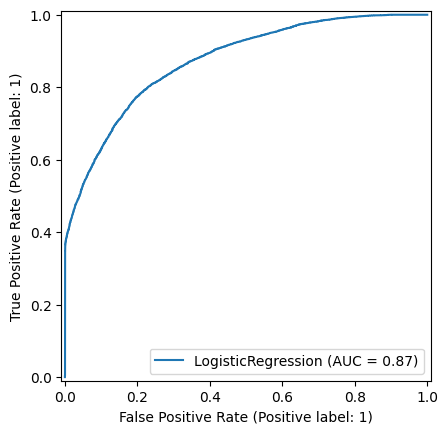

In [ ]:
best_logreg = search_lr.best_estimator_

# Menampilkan Kurva ROC-AUC
RocCurveDisplay.from_estimator(best_logreg, X_test_scaled, y_admit_test)
plt.show()

In [ ]:
# Mendapatkan koefisien regresi
coefs = search_lr.best_estimator_.coef_[0]

# Membuat DataFrame untuk menampilkan feature importance
feature_importance = pd.DataFrame({'feature': df_fi.columns, 'coef': coefs})
feature_importance = feature_importance.sort_values(by='coef', ascending=False)

# 10 fitur terpenting
top_10_features = feature_importance.head(10)

print(top_10_features)

                           feature      coef
9                           babies  2.111487
21            days_in_waiting_list  0.724841
25       total_of_special_requests  0.607163
0                            hotel  0.561623
15  previous_bookings_not_canceled  0.542195
26         reservation_status_date  0.365404
22                   customer_type  0.363214
23                             adr  0.218092
4        arrival_date_day_of_month  0.084652
18                    deposit_type  0.039764


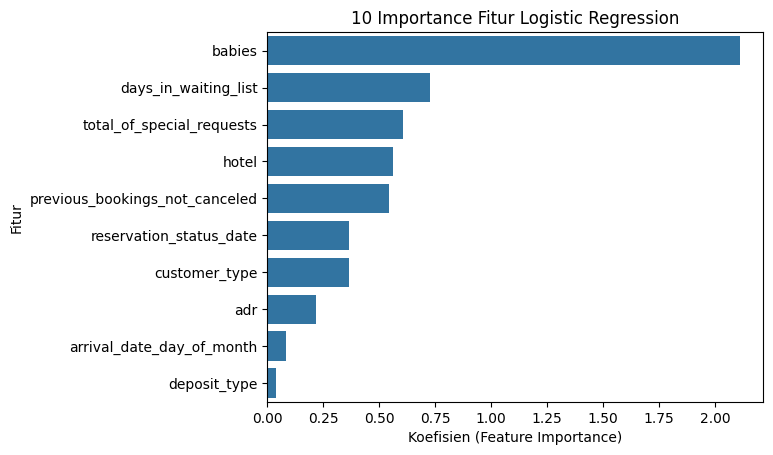

In [ ]:
# Visualisasi dengan bar plot
sns.barplot(x='coef', y='feature', data=top_10_features, orient='h')
plt.xlabel('Koefisien (Feature Importance)')
plt.ylabel('Fitur')
plt.title('10 Importance Fitur Logistic Regression')
plt.show()

#### Decision Tree

In [ ]:
# 2. Decision Tree
# Definisikan parameter yang ingin di-tuning
param_grid2 = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [5, 10, 20],
    'min_samples_leaf': [3, 5, 7]
}

# Membuat objek GridSearchCV + k-fold cross_validation
search_dt = GridSearchCV(dtree, param_grid2, cv=5, scoring='recall')
# Melatih model dengan GridSearchCV
search_dt.fit(X_train_scaled, y_admit_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [3, 5, 7],
                         'min_samples_split': [5, 10, 20]},
             scoring='recall')

In [ ]:
# results for Decision Tree
cv_result2 = pd.DataFrame(search_dt.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result2[retain_cols].sort_values('rank_test_score')

params  mean_test_score  \
18  {'max_depth': 20, 'min_samples_leaf': 3, 'min_...         0.876164   
22  {'max_depth': 20, 'min_samples_leaf': 5, 'min_...         0.874065   
21  {'max_depth': 20, 'min_samples_leaf': 5, 'min_...         0.874065   
19  {'max_depth': 20, 'min_samples_leaf': 3, 'min_...         0.873715   
24  {'max_depth': 20, 'min_samples_leaf': 7, 'min_...         0.871982   
25  {'max_depth': 20, 'min_samples_leaf': 7, 'min_...         0.871982   
26  {'max_depth': 20, 'min_samples_leaf': 7, 'min_...         0.871633   
23  {'max_depth': 20, 'min_samples_leaf': 5, 'min_...         0.871233   
20  {'max_depth': 20, 'min_samples_leaf': 3, 'min_...         0.870983   
9   {'max_depth': 15, 'min_samples_leaf': 3, 'min_...         0.866951   
10  {'max_depth': 15, 'min_samples_leaf': 3, 'min_...         0.866751   
12  {'max_depth': 15, 'min_samples_leaf': 5, 'min_...         0.865702   
13  {'max_depth': 15, 'min_samples_leaf': 5, 'min_...         0.865702   
11  {'max_depth': 15, 'min_samples_leaf': 3, 'min_...         0.865052   
14  {'max_depth': 15, 'min_samples_leaf': 5, 'min_...         0.864436   
15  {'max_depth': 15, 'min_samples_leaf': 7, 'min_...         0.864369   
16  {'max_depth': 15, 'min_samples_leaf': 7, 'min_...         0.864369   
17  {'max_depth': 15, 'min_samples_leaf': 7, 'min_...         0.864186   
2   {'max_depth': 10, 'min_samples_leaf': 3, 'min_...         0.810456   
1   {'max_depth': 10, 'min_samples_leaf': 3, 'min_...         0.810439   
0   {'max_depth': 10, 'min_samples_leaf': 3, 'min_...         0.810406   
8   {'max_depth': 10, 'min_samples_leaf': 7, 'min_...         0.810306   
5   {'max_depth': 10, 'min_samples_leaf': 5, 'min_...         0.810289   
7   {'max_depth': 10, 'min_samples_leaf': 7, 'min_...         0.810223   
6   {'max_depth': 10, 'min_samples_leaf': 7, 'min_...         0.810223   
4   {'max_depth': 10, 'min_samples_leaf': 5, 'min_...         0.810206   
3   {'max_depth': 10, 'min_samples_leaf': 5, 'min_...         0.810206   

    rank_test_score  
18                1  
22                2  
21                2  
19                4  
24                5  
25                5  
26                7  
23                8  
20                9  
9                10  
10               11  
12               12  
13               12  
11               14  
14               15  
15               16  
16               16  
17               18  
2                19  
1                20  
0                21  
8                22  
5                23  
7                24  
6                24  
4                26  
3                26

In [ ]:
y_train22 = search_dt.best_estimator_.predict(X_train_scaled)
y_pred22 = search_dt.best_estimator_.predict(X_test_scaled)

In [ ]:
# classification report Decision Tree
print("TRAIN DecisionTree:")
print(classification_report(y_admit_train, y_train22))
print("TEST DecisionTree:")
print(classification_report(y_admit_test, y_pred22))

TRAIN DecisionTree:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     59986
           1       0.93      0.93      0.93     60023

    accuracy                           0.93    120009
   macro avg       0.93      0.93      0.93    120009
weighted avg       0.93      0.93      0.93    120009

TEST DecisionTree:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88     15020
           1       0.88      0.88      0.88     14983

    accuracy                           0.88     30003
   macro avg       0.88      0.88      0.88     30003
weighted avg       0.88      0.88      0.88     30003



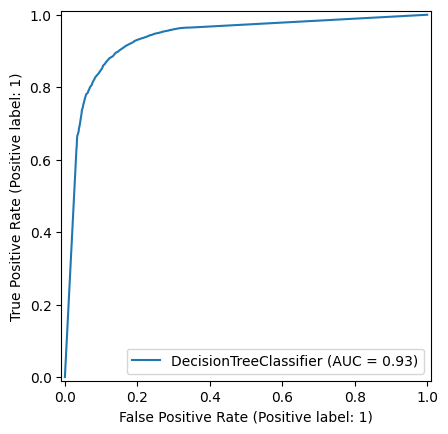

In [ ]:
best_dftree = search_dt.best_estimator_

# Menampilkan Kurva ROC-AUC
RocCurveDisplay.from_estimator(best_dftree, X_test_scaled, y_admit_test)
plt.show()

In [ ]:
# Mendapatkan nilai importance dari setiap fitur
importances = search_dt.best_estimator_.feature_importances_

# Membuat DataFrame untuk menampilkan feature importance
feature_importances2 = pd.DataFrame({'feature': df_fi.columns, 'importance': importances})
feature_importances2 = feature_importances2.sort_values('importance', ascending=False)

top_10_features2 = feature_importances2.head(10)
print(top_10_features2)

                           feature  importance
24     required_car_parking_spaces    0.247803
12            distribution_channel    0.146881
21            days_in_waiting_list    0.097422
0                            hotel    0.096141
25       total_of_special_requests    0.073129
17                 booking_changes    0.050962
26         reservation_status_date    0.047438
16              assigned_room_type    0.038407
15  previous_bookings_not_canceled    0.036423
1                        lead_time    0.026978


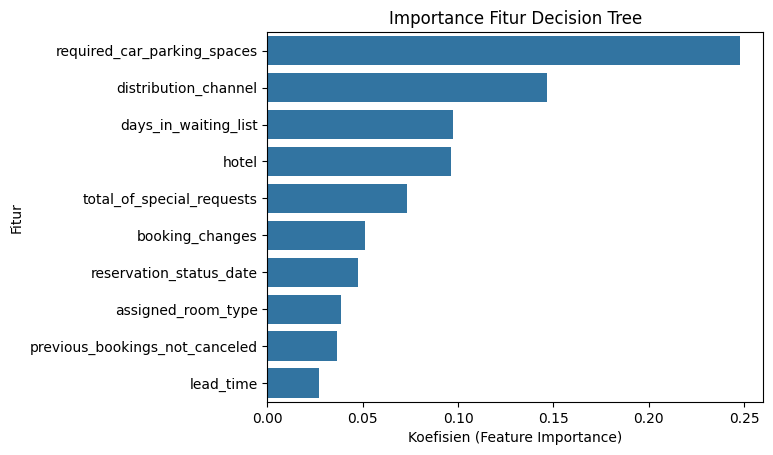

In [ ]:
# Visualisasi dengan bar plot
sns.barplot(x='importance', y='feature', data=top_10_features2, orient='h')
plt.xlabel('Koefisien (Feature Importance)')
plt.ylabel('Fitur')
plt.title('Importance Fitur Decision Tree')
plt.show()

#### Random Forest

In [ ]:
# 3. Random Forest
# Definisikan parameter yang ingin di-tuning
param_grid3 = {
    'n_estimators': [100, 120, 150],
    'max_depth': [10, 15, 20],
    'min_samples_split': [3, 5, 7],
    #'min_samples_leaf': [5, 7, 10]
}

# Membuat objek GridSearchCV + k-fold cross_validation
search_rf = GridSearchCV(rf, param_grid3, cv=5, scoring='recall')
# Melatih model dengan GridSearchCV
search_rf.fit(X_train_scaled, y_admit_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_split': [3, 5, 7],
                         'n_estimators': [100, 120, 150]},
             scoring='recall')

In [ ]:
# results for Random Forest
cv_result3 = pd.DataFrame(search_rf.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result3[retain_cols].sort_values('rank_test_score')

params  mean_test_score  \
18  {'max_depth': 20, 'min_samples_split': 3, 'n_e...         0.892208   
20  {'max_depth': 20, 'min_samples_split': 3, 'n_e...         0.892042   
19  {'max_depth': 20, 'min_samples_split': 3, 'n_e...         0.891675   
23  {'max_depth': 20, 'min_samples_split': 5, 'n_e...         0.890076   
21  {'max_depth': 20, 'min_samples_split': 5, 'n_e...         0.890009   
22  {'max_depth': 20, 'min_samples_split': 5, 'n_e...         0.889976   
25  {'max_depth': 20, 'min_samples_split': 7, 'n_e...         0.888376   
26  {'max_depth': 20, 'min_samples_split': 7, 'n_e...         0.888176   
24  {'max_depth': 20, 'min_samples_split': 7, 'n_e...         0.887510   
10  {'max_depth': 15, 'min_samples_split': 3, 'n_e...         0.861287   
11  {'max_depth': 15, 'min_samples_split': 3, 'n_e...         0.861237   
9   {'max_depth': 15, 'min_samples_split': 3, 'n_e...         0.861237   
13  {'max_depth': 15, 'min_samples_split': 5, 'n_e...         0.859587   
15  {'max_depth': 15, 'min_samples_split': 7, 'n_e...         0.859487   
14  {'max_depth': 15, 'min_samples_split': 5, 'n_e...         0.859471   
17  {'max_depth': 15, 'min_samples_split': 7, 'n_e...         0.859004   
16  {'max_depth': 15, 'min_samples_split': 7, 'n_e...         0.858888   
12  {'max_depth': 15, 'min_samples_split': 5, 'n_e...         0.858838   
4   {'max_depth': 10, 'min_samples_split': 5, 'n_e...         0.806974   
5   {'max_depth': 10, 'min_samples_split': 5, 'n_e...         0.806508   
3   {'max_depth': 10, 'min_samples_split': 5, 'n_e...         0.805825   
1   {'max_depth': 10, 'min_samples_split': 3, 'n_e...         0.805525   
2   {'max_depth': 10, 'min_samples_split': 3, 'n_e...         0.805341   
0   {'max_depth': 10, 'min_samples_split': 3, 'n_e...         0.805158   
6   {'max_depth': 10, 'min_samples_split': 7, 'n_e...         0.804942   
7   {'max_depth': 10, 'min_samples_split': 7, 'n_e...         0.804042   
8   {'max_depth': 10, 'min_samples_split': 7, 'n_e...         0.803759   

    rank_test_score  
18                1  
20                2  
19                3  
23                4  
21                5  
22                6  
25                7  
26                8  
24                9  
10               10  
11               11  
9                12  
13               13  
15               14  
14               15  
17               16  
16               17  
12               18  
4                19  
5                20  
3                21  
1                22  
2                23  
0                24  
6                25  
7                26  
8                27

In [ ]:
y_train33 = search_rf.best_estimator_.predict(X_train_scaled)
y_pred33 = search_rf.best_estimator_.predict(X_test_scaled)

In [ ]:
# classification report Random Forest
print("TRAIN RandomForest:")
print(classification_report(y_admit_train, y_train33))
print("TEST RandomForest:")
print(classification_report(y_admit_test, y_pred33))

TRAIN RandomForest:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     59986
           1       0.95      0.95      0.95     60023

    accuracy                           0.95    120009
   macro avg       0.95      0.95      0.95    120009
weighted avg       0.95      0.95      0.95    120009

TEST RandomForest:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     15020
           1       0.92      0.90      0.91     14983

    accuracy                           0.91     30003
   macro avg       0.91      0.91      0.91     30003
weighted avg       0.91      0.91      0.91     30003



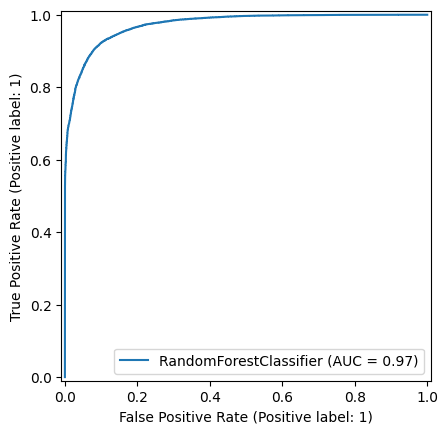

In [ ]:
best_rf = search_rf.best_estimator_

# Menampilkan Kurva ROC-AUC
RocCurveDisplay.from_estimator(best_rf, X_test_scaled, y_admit_test)
plt.show()

In [ ]:
# Mendapatkan nilai importance dari setiap fitur
importances = search_rf.best_estimator_.feature_importances_

# Membuat DataFrame untuk menampilkan feature importance
feature_importances3 = pd.DataFrame({'feature': df_fi.columns, 'importance': importances})
feature_importances3 = feature_importances3.sort_values('importance', ascending=False)

top_10_features3 = feature_importances3.head(10)
print(top_10_features3)

                           feature  importance
21            days_in_waiting_list    0.133644
24     required_car_parking_spaces    0.122152
0                            hotel    0.108514
12            distribution_channel    0.094879
17                 booking_changes    0.066920
26         reservation_status_date    0.060749
15  previous_bookings_not_canceled    0.057285
25       total_of_special_requests    0.052994
23                             adr    0.038296
16              assigned_room_type    0.032738


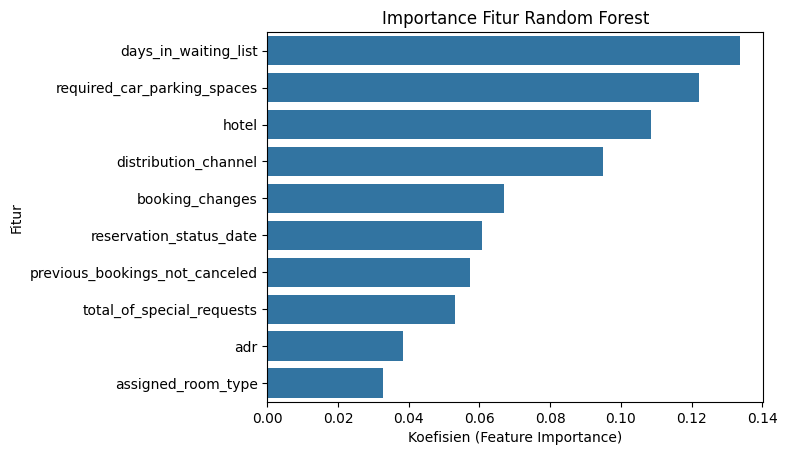

In [ ]:
# Visualisasi dengan bar plot
sns.barplot(x='importance', y='feature', data=top_10_features3, orient='h')
plt.xlabel('Koefisien (Feature Importance)')
plt.ylabel('Fitur')
plt.title('Importance Fitur Random Forest')
plt.show()

#### SVM

In [ ]:
# 4. SVM - kernel Linear

SVMlin = SVC(kernel='linear') # kernel linear, c = 1.0

SVMlin.fit(X_train_scaled, y_admit_train)
y_train441 = SVMlin.predict(X_train_scaled)
y_pred441 = SVMlin.predict(X_test_scaled)

In [ ]:
# classification report SVM - Linear
print("TRAIN SVM-Linear:")
print(classification_report(y_admit_train, y_train441))
print("TEST SVM-Linear:")
print(classification_report(y_admit_test, y_pred441))

TRAIN SVM-Linear:
              precision    recall  f1-score   support

           0       0.78      0.81      0.80     59986
           1       0.80      0.77      0.79     60023

    accuracy                           0.79    120009
   macro avg       0.79      0.79      0.79    120009
weighted avg       0.79      0.79      0.79    120009

TEST SVM-Linear:
              precision    recall  f1-score   support

           0       0.78      0.80      0.79     15020
           1       0.80      0.77      0.78     14983

    accuracy                           0.79     30003
   macro avg       0.79      0.79      0.79     30003
weighted avg       0.79      0.79      0.79     30003



In [ ]:
# Get feature importance for linear kernel
feature_importance41 = abs(SVMlin.coef_[0])
print("Feature Importance:", feature_importance41)

Feature Importance: [5.19603565e-01 7.39780498e-02 1.43135728e-02 2.88761382e-02
 9.13097539e-02 5.66910624e-03 1.89360644e-03 6.31886711e-03
 1.76473689e-01 1.70551107e+00 3.27008785e-01 3.01968218e-01
 1.33698799e-03 3.03209258e-02 7.33106738e-02 5.59198280e-01
 4.53809225e+00 6.02623601e-01 5.10281131e-03 1.50653249e-01
 1.20747450e-01 6.49926113e-01 3.71235819e-01 1.96912671e-01
 5.69196272e-01 5.22731415e-01 3.37482764e-01]


In [ ]:
# 4. SVM - kernel Polynomial

SVMpoly = SVC(kernel='poly') # kernel poly, c = 1.0

SVMpoly.fit(X_train_scaled, y_admit_train)
y_train442 = SVMpoly.predict(X_train_scaled)
y_pred442 = SVMpoly.predict(X_test_scaled)

In [ ]:
# classification report SVM - Polynomial
print("TRAIN SVM-Poly:")
print(classification_report(y_admit_train, y_train442))
print("TEST SVM-Poly:")
print(classification_report(y_admit_test, y_pred442))

TRAIN SVM-Poly:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85     59986
           1       0.85      0.84      0.85     60023

    accuracy                           0.85    120009
   macro avg       0.85      0.85      0.85    120009
weighted avg       0.85      0.85      0.85    120009

TEST SVM-Poly:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84     15020
           1       0.84      0.83      0.84     14983

    accuracy                           0.84     30003
   macro avg       0.84      0.84      0.84     30003
weighted avg       0.84      0.84      0.84     30003



In [ ]:
# Calculate permutation importance - SVM Polynomial
result42 = permutation_importance(SVMpoly, X_train_scaled, y_admit_train, n_repeats=10, random_state=42)
feature_importance42 = result42.importances_mean
print("Feature Importance:", feature_importance42)

In [ ]:
# 4. SVM - kernel Radial Basis Function (RBF)

SVMrbf = SVC(kernel='rbf') # kernel rbf, c = 1.0

SVMrbf.fit(X_train_scaled, y_admit_train)
y_train443 = SVMrbf.predict(X_train_scaled)
y_pred443 = SVMrbf.predict(X_test_scaled)

In [ ]:
# classification report SVM - Radial Basis Function (RBF)
print("TRAIN SVM-RBF:")
print(classification_report(y_admit_train, y_train443))
print("TEST SVM-RBF:")
print(classification_report(y_admit_test, y_pred443))

TRAIN SVM-RBF:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86     59986
           1       0.88      0.84      0.86     60023

    accuracy                           0.86    120009
   macro avg       0.86      0.86      0.86    120009
weighted avg       0.86      0.86      0.86    120009

TEST SVM-RBF:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85     15020
           1       0.87      0.83      0.85     14983

    accuracy                           0.85     30003
   macro avg       0.85      0.85      0.85     30003
weighted avg       0.85      0.85      0.85     30003



In [ ]:
# Calculate permutation importance - SVM Polynomial
result43 = permutation_importance(SVMrbf, X_train_scaled, y_admit_train, n_repeats=10, random_state=42)
feature_importance43 = result43.importances_mean
print("Feature Importance:", feature_importance43)

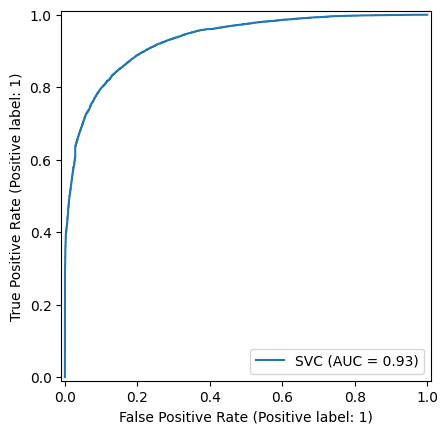

In [ ]:
best_svm = SVMrbf

# Menampilkan Kurva ROC-AUC
RocCurveDisplay.from_estimator(best_svm, X_test_scaled, y_admit_test)
plt.show()

#### Neural Network (MLP)

In [ ]:
# 5. Neural Network (MLP)
# Definisikan parameter yang ingin di-tuning
param_grid5 = {
    'hidden_layer_sizes': [(50,), (100,), (150,)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'adaptive']
}

# Membuat objek RandomizedSearchCV + k-fold cross_validation
search_mlp = RandomizedSearchCV(mlp, param_grid5, cv=3, scoring='recall')
# Melatih model dengan GridSearchCV
search_mlp.fit(X_train_scaled, y_admit_train)

RandomizedSearchCV(cv=3,
                   estimator=MLPClassifier(max_iter=1000, random_state=42),
                   param_distributions={'activation': ['relu'],
                                        'alpha': [0.0001, 0.001],
                                        'hidden_layer_sizes': [(50,), (100,),
                                                               (150,)],
                                        'learning_rate': ['constant',
                                                          'adaptive'],
                                        'solver': ['adam']},
                   scoring='recall')

In [ ]:
# results for Neural Network (MLP)
cv_result5 = pd.DataFrame(search_mlp.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result5[retain_cols].sort_values('rank_test_score')

params  mean_test_score  \
7  {'solver': 'adam', 'learning_rate': 'adaptive'...         0.880613   
8  {'solver': 'adam', 'learning_rate': 'constant'...         0.880613   
9  {'solver': 'adam', 'learning_rate': 'adaptive'...         0.873698   
5  {'solver': 'adam', 'learning_rate': 'constant'...         0.866968   
0  {'solver': 'adam', 'learning_rate': 'adaptive'...         0.864802   
3  {'solver': 'adam', 'learning_rate': 'constant'...         0.864802   
1  {'solver': 'adam', 'learning_rate': 'constant'...         0.863769   
4  {'solver': 'adam', 'learning_rate': 'adaptive'...         0.863769   
2  {'solver': 'adam', 'learning_rate': 'adaptive'...         0.845942   
6  {'solver': 'adam', 'learning_rate': 'constant'...         0.845942   

   rank_test_score  
7                1  
8                1  
9                3  
5                4  
0                5  
3                5  
1                7  
4                7  
2                9  
6                9

In [ ]:
y_train55 = search_mlp.best_estimator_.predict(X_train_scaled)
y_pred55 = search_mlp.best_estimator_.predict(X_test_scaled)

In [ ]:
# classification report MLP
print("TRAIN MLP:")
print(classification_report(y_admit_train, y_train55))
print("TEST MLP:")
print(classification_report(y_admit_test, y_pred55))

TRAIN MLP:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88     59986
           1       0.90      0.86      0.88     60023

    accuracy                           0.88    120009
   macro avg       0.88      0.88      0.88    120009
weighted avg       0.88      0.88      0.88    120009

TEST MLP:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87     15020
           1       0.88      0.85      0.87     14983

    accuracy                           0.87     30003
   macro avg       0.87      0.87      0.87     30003
weighted avg       0.87      0.87      0.87     30003



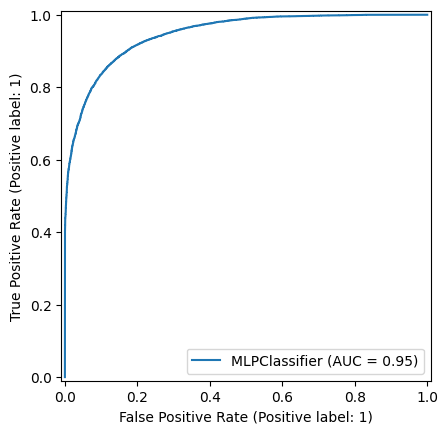

In [ ]:
best_mlp = search_mlp.best_estimator_

# Menampilkan Kurva ROC-AUC
RocCurveDisplay.from_estimator(best_mlp, X_test_scaled, y_admit_test)
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

# Ambil model terbaik
best_model = search_mlp.best_estimator_

# Hitung permutation importance
result = permutation_importance(best_model, X_test_scaled, y_admit_test, n_repeats=10, random_state=42, n_jobs=-1)
importance5 = result.importances_mean

# Buat DataFrame untuk feature importance
feature_importances5 = pd.DataFrame({'feature': df_fi.columns, 'importance': importance5})
feature_importances5 = feature_importances5.sort_values(by='importance', ascending=False)

top_10_features5 = feature_importances5.head(10)
print(top_10_features5)

                           feature  importance
15  previous_bookings_not_canceled    0.072089
0                            hotel    0.069866
21            days_in_waiting_list    0.067053
12            distribution_channel    0.059684
18                    deposit_type    0.051008
25       total_of_special_requests    0.048732
17                 booking_changes    0.046325
24     required_car_parking_spaces    0.044982
1                        lead_time    0.033970
9                           babies    0.028111


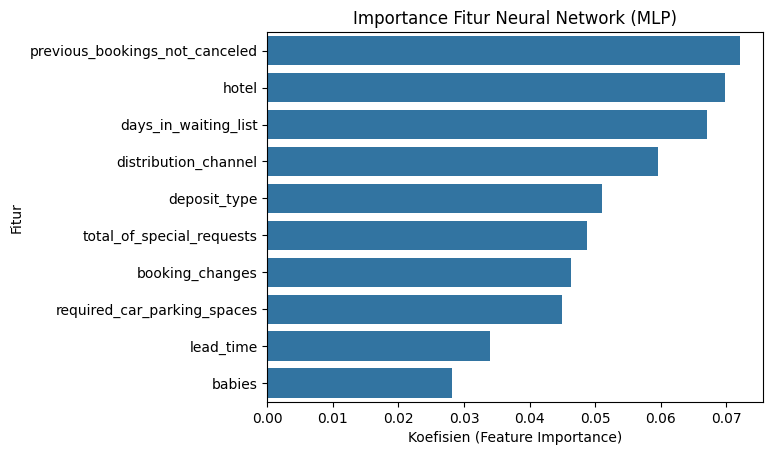

In [ ]:
# Visualisasi dengan bar plot
sns.barplot(x='importance', y='feature', data=top_10_features5, orient='h')
plt.xlabel('Koefisien (Feature Importance)')
plt.ylabel('Fitur')
plt.title('Importance Fitur Neural Network (MLP)')
plt.show()

#### XGBoost

In [ ]:
# 6. XGBoost
import xgboost as xgb
# Initialize XGBoost classifier
model_xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=-1)

# Definisikan parameter yang akan di-tune
param_grid6 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
    'reg_alpha': [0.01, 0.1, 1],            # L1 regularization
    'reg_lambda': [0.01, 0.1, 1]            # L2 regularization
}

# Membuat objek GridSearchCV + k-fold cross_validation
search_xgb = GridSearchCV(model_xgb, param_grid6, cv=5, scoring='recall')

# Melatih model dengan GridSearchCV
search_xgb.fit(X_train_scaled, y_admit_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=42, ...),
             param_grid={'max_depth': [5, 7, 10],
                         'n_estimators': [50, 100, 200],
                         'reg_alpha': [0.01, 0.1, 1],
                         'reg_lambda': [0.01, 0.1, 1]},
             scoring='recall')

Here are some important hyperparameters to tune for XGBoost:

- n_estimators: Number of boosting rounds (trees).
- max_depth: Maximum depth of a tree.
- learning_rate: Step size shrinkage to prevent overfitting.
- subsample: Fraction of samples used for training each tree.
- colsample_bytree: Fraction of features used for training each tree.
- gamma: Minimum loss reduction required to make a split.
- reg_alpha: L1 regularization term (for feature selection).
- reg_lambda: L2 regularization term.

In [ ]:
# results for XGBoost
cv_result6 = pd.DataFrame(search_xgb.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result6[retain_cols].sort_values('rank_test_score')

params  mean_test_score  \
76  {'max_depth': 10, 'n_estimators': 200, 'reg_al...         0.937724   
77  {'max_depth': 10, 'n_estimators': 200, 'reg_al...         0.937257   
79  {'max_depth': 10, 'n_estimators': 200, 'reg_al...         0.937174   
73  {'max_depth': 10, 'n_estimators': 200, 'reg_al...         0.936791   
74  {'max_depth': 10, 'n_estimators': 200, 'reg_al...         0.936674   
..                                                ...              ...   
8   {'max_depth': 5, 'n_estimators': 50, 'reg_alph...         0.869600   
3   {'max_depth': 5, 'n_estimators': 50, 'reg_alph...         0.869517   
6   {'max_depth': 5, 'n_estimators': 50, 'reg_alph...         0.869483   
2   {'max_depth': 5, 'n_estimators': 50, 'reg_alph...         0.869350   
5   {'max_depth': 5, 'n_estimators': 50, 'reg_alph...         0.869134   

    rank_test_score  
76                1  
77                2  
79                3  
73                4  
74                5  
..              ...  
8                77  
3                78  
6                79  
2                80  
5                81  

[81 rows x 3 columns]

In [ ]:
y_train66 = search_xgb.best_estimator_.predict(X_train_scaled)
y_pred66 = search_xgb.best_estimator_.predict(X_test_scaled)

In [ ]:
# classification report XGBoost
print("TRAIN XGBoost:")
print(classification_report(y_admit_train, y_train66))
print("TEST XGBoost:")
print(classification_report(y_admit_test, y_pred66))

TRAIN XGBoost:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59986
           1       1.00      1.00      1.00     60023

    accuracy                           1.00    120009
   macro avg       1.00      1.00      1.00    120009
weighted avg       1.00      1.00      1.00    120009

TEST XGBoost:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     15020
           1       0.96      0.95      0.95     14983

    accuracy                           0.95     30003
   macro avg       0.96      0.95      0.95     30003
weighted avg       0.96      0.95      0.95     30003



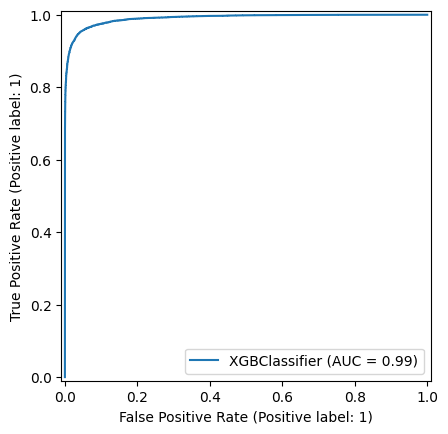

In [ ]:
best_xgb = search_xgb.best_estimator_

# Menampilkan Kurva ROC-AUC
RocCurveDisplay.from_estimator(best_xgb, X_test_scaled, y_admit_test)
plt.show()

In [ ]:
# Ambil model terbaik
best_model = search_xgb.best_estimator_

# Feature importance
importance_xgb = best_model.feature_importances_

# Membuat DataFrame untuk menampilkan feature importance
feature_importances6 = pd.DataFrame({'feature': df_fi.columns, 'importance': importance_xgb})
feature_importances6 = feature_importances6.sort_values('importance', ascending=False)

top_10_features6 = feature_importances6.head(10)
print(top_10_features6)

                        feature  importance
24  required_car_parking_spaces    0.718154
16           assigned_room_type    0.152845
9                        babies    0.025124
25    total_of_special_requests    0.023045
12         distribution_channel    0.010688
11                      country    0.006784
17              booking_changes    0.006662
14       previous_cancellations    0.006323
22                customer_type    0.006073
21         days_in_waiting_list    0.005611


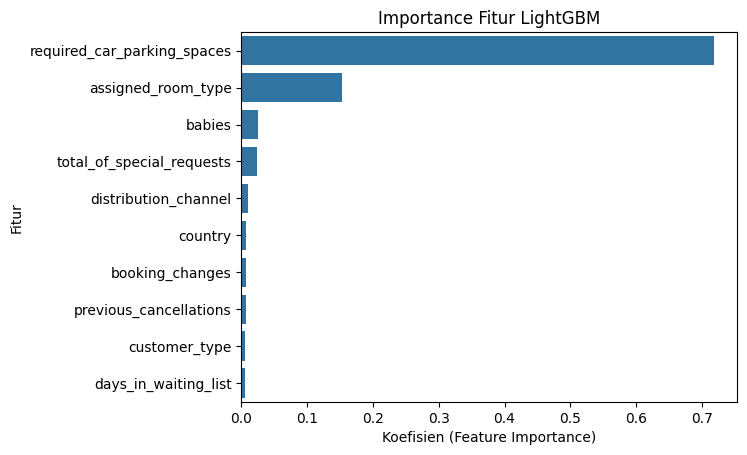

In [ ]:
# Visualisasi dengan bar plot
sns.barplot(x='importance', y='feature', data=top_10_features6, orient='h')
plt.xlabel('Koefisien (Feature Importance)')
plt.ylabel('Fitur')
plt.title('Importance Fitur LightGBM')
plt.show()

#### LightGBM

In [ ]:
# 7. LightGBM

# Definisikan parameter yang akan di-tune
param_grid7 = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 7, 10],
    'reg_alpha': [0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [0.01, 0.1, 1]  # L2 regularization
}

# Membuat objek GridSearchCV + k-fold cross_validation
search_lgbm = GridSearchCV(lgb, param_grid7, cv=5, scoring='recall')

# Melatih model dengan GridSearchCV
search_lgbm.fit(X_train_scaled, y_admit_train)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

GridSearchCV(cv=5, estimator=LGBMClassifier(random_state=42),
             param_grid={'max_depth': [5, 7, 10],
                         'n_estimators': [50, 100, 200],
                         'reg_alpha': [0.01, 0.1, 1],
                         'reg_lambda': [0.01, 0.1, 1]},
             scoring='recall')

In [ ]:
# results for LightGBM
cv_result7 = pd.DataFrame(search_lgbm.cv_results_)
retain_cols = ['params','mean_test_score','rank_test_score']
cv_result7[retain_cols].sort_values('rank_test_score')

params  mean_test_score  \
75  {'max_depth': 10, 'n_estimators': 200, 'reg_al...         0.893674   
76  {'max_depth': 10, 'n_estimators': 200, 'reg_al...         0.893641   
79  {'max_depth': 10, 'n_estimators': 200, 'reg_al...         0.893541   
73  {'max_depth': 10, 'n_estimators': 200, 'reg_al...         0.893441   
80  {'max_depth': 10, 'n_estimators': 200, 'reg_al...         0.893374   
..                                                ...              ...   
5   {'max_depth': 5, 'n_estimators': 50, 'reg_alph...         0.827350   
4   {'max_depth': 5, 'n_estimators': 50, 'reg_alph...         0.827333   
2   {'max_depth': 5, 'n_estimators': 50, 'reg_alph...         0.827316   
0   {'max_depth': 5, 'n_estimators': 50, 'reg_alph...         0.826500   
8   {'max_depth': 5, 'n_estimators': 50, 'reg_alph...         0.826367   

    rank_test_score  
75                1  
76                2  
79                3  
73                4  
80                5  
..              ...  
5                77  
4                78  
2                79  
0                80  
8                81  

[81 rows x 3 columns]

In [ ]:
y_train77 = search_lgbm.best_estimator_.predict(X_train_scaled)
y_pred77 = search_lgbm.best_estimator_.predict(X_test_scaled)

In [ ]:
# classification report LightGBM
print("TRAIN LightGBM:")
print(classification_report(y_admit_train, y_train77))
print("TEST LightGBM:")
print(classification_report(y_admit_test, y_pred77))

TRAIN LightGBM:
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     59986
           1       0.93      0.90      0.91     60023

    accuracy                           0.92    120009
   macro avg       0.92      0.92      0.92    120009
weighted avg       0.92      0.92      0.92    120009

TEST LightGBM:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     15020
           1       0.92      0.90      0.91     14983

    accuracy                           0.91     30003
   macro avg       0.91      0.91      0.91     30003
weighted avg       0.91      0.91      0.91     30003



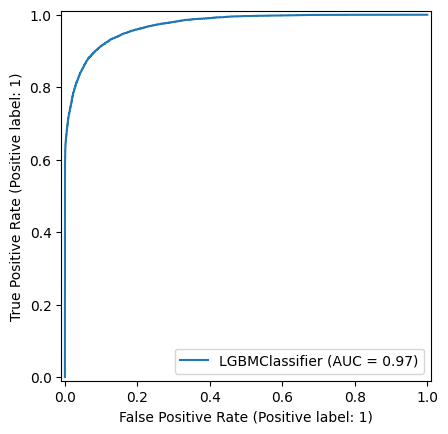

In [ ]:
best_lgbm = search_lgbm.best_estimator_

# Menampilkan Kurva ROC-AUC
RocCurveDisplay.from_estimator(best_lgbm, X_test_scaled, y_admit_test)
plt.show()

In [ ]:
# Ambil model terbaik
best_model = search_lgbm.best_estimator_

# Feature importance
importance_lgbm = best_model.feature_importances_

# Membuat DataFrame untuk menampilkan feature importance
feature_importances7 = pd.DataFrame({'feature': df_fi.columns, 'importance': importance_lgbm})
feature_importances7 = feature_importances7.sort_values('importance', ascending=False)

top_10_features7 = feature_importances7.head(10)
print(top_10_features7)

                           feature  importance
26         reservation_status_date        1019
21            days_in_waiting_list         616
0                            hotel         571
1                        lead_time         545
12            distribution_channel         529
15  previous_bookings_not_canceled         435
19                           agent         317
2               arrival_date_month         317
25       total_of_special_requests         226
23                             adr         199


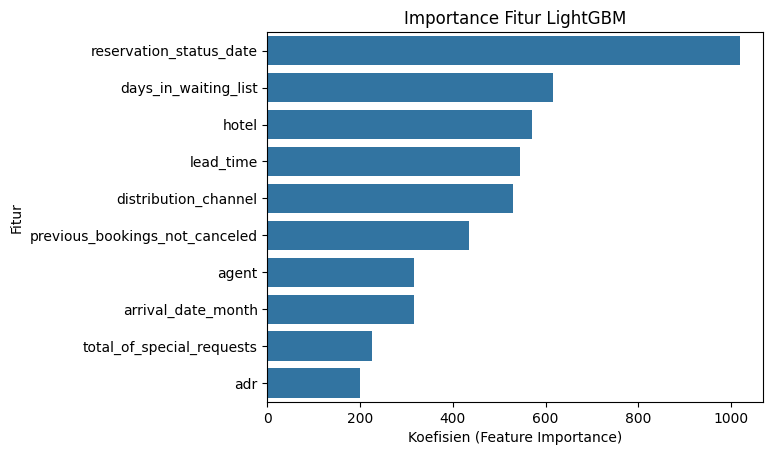

In [ ]:
# Visualisasi dengan bar plot
sns.barplot(x='importance', y='feature', data=top_10_features7, orient='h')
plt.xlabel('Koefisien (Feature Importance)')
plt.ylabel('Fitur')
plt.title('Importance Fitur LightGBM')
plt.show()

### Confusion Matrix

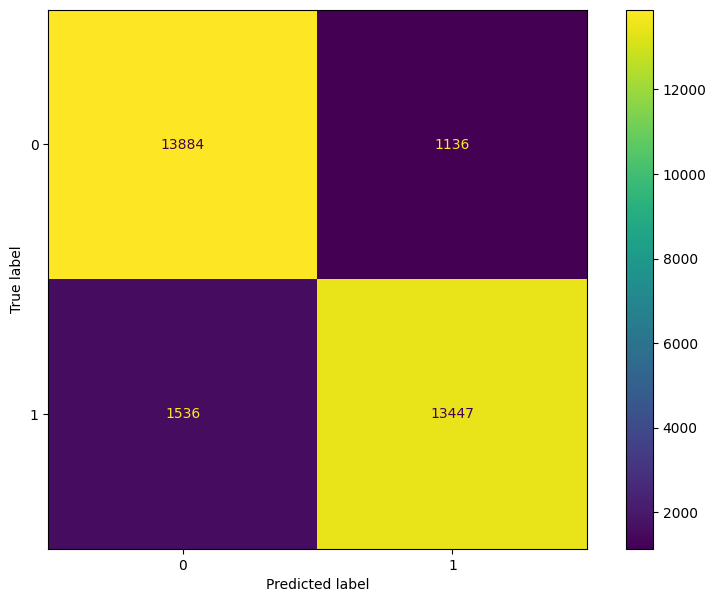

In [ ]:
# Best Model 1 : Random Forest
# Hasil dengan Recall

fig, ax = plt.subplots(figsize=(10,7))

cm1 = confusion_matrix(y_admit_test, y_pred33, labels=best_rf.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1,
                             display_labels=best_rf.classes_)
disp1.plot(ax=ax)
plt.show()

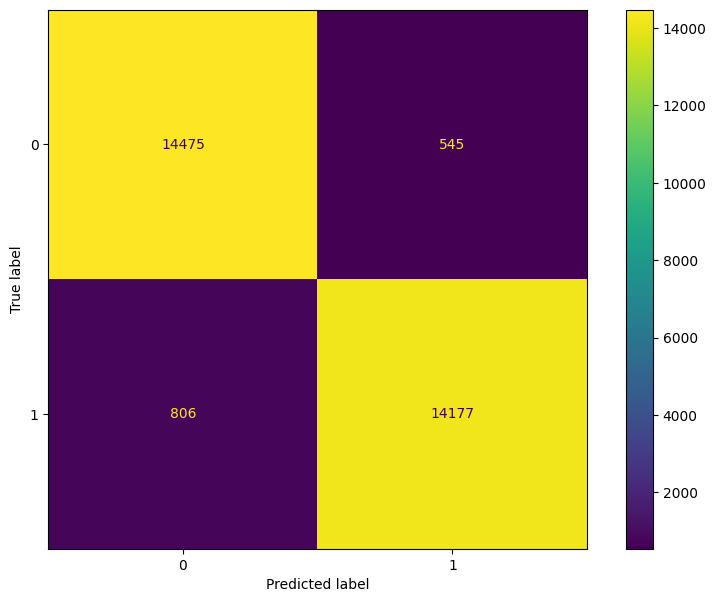

In [ ]:
# Best Model 2 : XGBoost
# Hasil dengan Recall

fig, ax = plt.subplots(figsize=(10,7))

cm2 = confusion_matrix(y_admit_test, y_pred66, labels=best_xgb.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2,
                             display_labels=best_xgb.classes_)
disp2.plot(ax=ax)
plt.show()

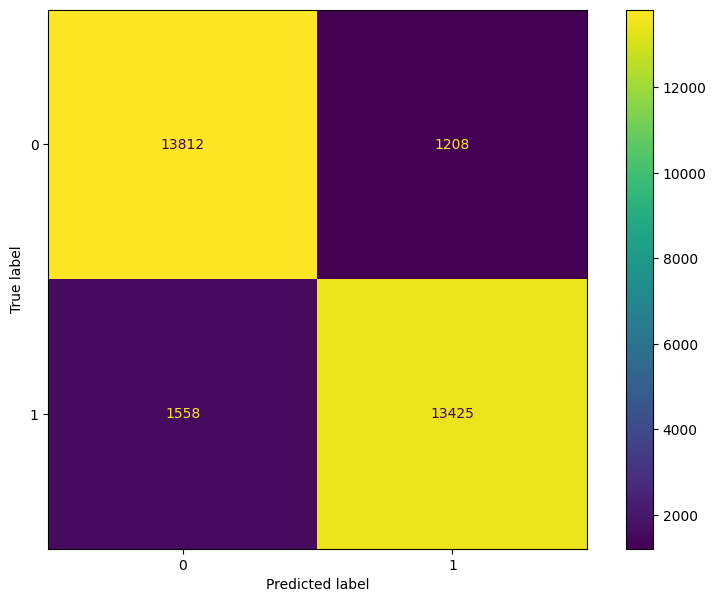

In [ ]:
# Best Model 3 : LightGBM
# Hasil dengan Recall

fig, ax = plt.subplots(figsize=(10,7))

cm3 = confusion_matrix(y_admit_test, y_pred77, labels=best_lgbm.classes_)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3,
                             display_labels=best_lgbm.classes_)
disp3.plot(ax=ax)
plt.show()

## Kesimpulan

- Hasil prediksi target yakni pembatalan reservasi hotel lebih mudah dikenali melalui Model Random Forest, XGBoost dan LightGBM dengan ketepatan prediksi 90% (Recall) serta memiliki akurasi 91% dalam posisi data yang telah balance.
- Hasil Tuning Hyperparameter dari masing-masing model terbukti mampu meningkatkan hasil prediksi terhadap pembatalan reservasi pada testing data sebagai berikut (Recall):
1. Logistic Regression : 0.78 (Baseline)
2. Decision Forest: 0.88
3. Random Forest: 0.90
4. Support Vector Machine: 0.83
5. Neural Network (MLP): 0.85
6. XGBoost: 0.95
7. LightGBM: 0.90
- Fitur kunci berdasarkan hasil model untuk memprediksi pembatalan reservasi lebih mengarah pada beberapa faktor berikut:
1. **Ketersediaan fasilitas:** required_car_parking_spaces dan total_of_special_requests.
2. **Manajemen Riwayat Pemesanan:** reservation_status_date, days_in_waiting_list dan is_repeated_guest.

## Rekomendasi

- Penerapan program loyalitas seperti memberikan penawaran khusus, diskon, atau upgrade kamar secara eksklusif untuk tamu loyal dan melakukan komunikasi yang lebih personal.
- Optimalkan pelayanan terutama pada musim atau waktu liburan.
- Melakukan pelatihan untuk staf demi memberikan pelayanan yang lebih baik, ramah, dan proaktif. Memperhatikan detail kecil yang dapat meningkatkan kepuasan tamu, seperti penyediaan fasilitas tambahan atau perlakuan khusus. Serta manajemen komplain yang cepat dan efektif untuk meminimalisir dampak negatif terhadap reputasi hotel.
- Mengulas kembali kebijakan pembatalan untuk menawarkan opsi pembatalan yang lebih fleksibel, terutama untuk tamu loyal.
- Berikan insentif kepada tamu yang merekomendasikan hotel kepada teman atau keluarga serta melakukan survei secara berkala untuk mendapatkan feedback langsung dari tamu.
- Pertimbangkan potensi pemakaian media sosial untuk berinteraksi dengan tamu dan membangun komunitas.


## **Terima Kasih**

Terbuka untuk diskusi, pemberian saran dan masukan. Silahkan hubungi kotak saya:

- LinkedIn : www.linkedin.com/in/hudzaifahrizqikamil
- Email : hudzaifahrizqikamil@gmail.com
- Phone : (+62)85710864942